In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    agg.columns = names

    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(84):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(84):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(21):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    # Transform each weather station as a separate "batch"
    for ws in range(21):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 11:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 6
if n_seq > 46:
    n_lag = 179 - n_seq + 46
else:
    n_lag = 179
n_time_steps = 227
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 
                        23, 24, 25, 27, 28, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
                        43, 44, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 
                        62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 
                        82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 100, 101, 102, 103])
test_array.append([0, 4, 10, 12, 18, 26, 30, 31, 33, 45, 47, 53, 64, 65, 77, 80, 89, 94, 96, 99, 104])
    
train_array.append([0, 1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 23, 
                        24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 41, 43, 45, 
                        46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 63, 64, 
                        65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 80, 81, 82, 83, 84, 
                        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104])
test_array.append([5, 9, 11, 15, 16, 22, 28, 35, 39, 40, 42, 44, 55, 56, 62, 72, 76, 78, 79, 85, 103])
    
train_array.append([0, 1, 2, 4, 5, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23, 26, 
                    28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 
                    48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 
                    70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 89, 
                    90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104])
test_array.append([3, 6, 7, 8, 13, 17, 19, 24, 25, 27, 34, 38, 43, 49, 66, 67, 68, 69, 73, 81, 84])
    
train_array.append([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 
                        35, 37, 38, 39, 40, 42, 43, 44, 45, 47, 49, 51, 52, 53, 55, 56, 
                        60, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 
                        80, 81, 82, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 99, 102, 103, 104])
test_array.append([32, 36, 41, 46, 48, 50, 54, 57, 58, 59, 61, 63, 70, 75, 83, 90, 91, 97, 98, 100, 101])
    
train_array.append([0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22,
                        24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 
                        42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 
                        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 
                        79, 80, 81, 83, 84, 85, 89, 90, 91, 94, 96, 97, 98, 99, 100, 101, 103, 104])
test_array.append([1, 2, 14, 20, 21, 23, 29, 37, 51, 52, 60, 71, 74, 82, 86, 87, 88, 92, 93, 95, 102])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Monthly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['Day', 'vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'Month', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when solar activity is removed as a predictor
df_trimmed = df_trimmed.drop(['solar_activity'], axis=1)

n_vars = df_trimmed.shape[1]-1
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    #new_df = new_df.iloc[:180, :]
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['specific_humidity'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)
    
#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    for k in range(84):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(84):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(21):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(21):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(84):
        train2.append(train1[k][0])
        
    for k in range(11):
        test2.append(test1[k][0])

    for k in range(10):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(84, dim_size)
    test1 = np.array(test[i]).reshape(11, dim_size)
    validation1 = np.array(validation[i]).reshape(10, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 179
n_seq (number of output/future prediction time steps): 6
C:\Users\User
C:\Users\User\Modeling\
             date  file_id  specific_humidity          slp  vapor_pressure  \
0      2006-01-31     6501           5.386935  1018.534543        8.674922   
1      2006-02-28     6501           4.299929  1021.230347        6.942276   
2      2006-03-31     6501           6.505135  1018.968548       10.468176   
3      2006-04-30     6501          10.211263  1014.686944       16.358802   
4      2006-05-31     6501          11.737971  1014.236828       18.798749   
...           ...      ...                ...          ...             ...   
24057  2024-07-31     9858          15.211417  1013.969355       23.769169   
24058  2024-08-31     9858          15.149811  1015.112097       23.699154   
24059  2024-09-30     9858          10.720199  1014.393750       16.790240   
24060  2024-10-31     9858           6.989922  1018.230376       10

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

6
179
(84, 1975)
(11, 1975)


[I 2025-05-27 12:38:35,096] A new study created in memory with name: no-name-36cf5d7b-6b44-46f6-b3b4-10c24845e6f5
[I 2025-05-27 12:43:44,247] Trial 0 finished with value: 0.06477416977286339 and parameters: {'lr': 0.09206140882139853, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.14663086799580613}. Best is trial 0 with value: 0.06477416977286339.


Cross Validation Accuracies:
[0.06090026721358299, 0.061012689024209976, 0.07406193017959595, 0.06819526106119156, 0.059700701385736465]
Mean Cross Validation Accuracy:
0.06477416977286339
Standard Deviation of Cross Validation Accuracy:
0.0055292368173629446


[I 2025-05-27 12:48:42,484] Trial 1 finished with value: 0.12892275154590607 and parameters: {'lr': 0.06560672785920459, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.23991799662573757}. Best is trial 0 with value: 0.06477416977286339.


Cross Validation Accuracies:
[0.13649795949459076, 0.12494774162769318, 0.1305011659860611, 0.1337842345237732, 0.11888265609741211]
Mean Cross Validation Accuracy:
0.12892275154590607
Standard Deviation of Cross Validation Accuracy:
0.006326348153865031


[I 2025-05-27 12:56:51,912] Trial 2 finished with value: 0.09429493993520736 and parameters: {'lr': 0.003033967731333001, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.204726489090287}. Best is trial 0 with value: 0.06477416977286339.


Cross Validation Accuracies:
[0.10202405601739883, 0.09594542533159256, 0.08681652694940567, 0.09569723904132843, 0.09099145233631134]
Mean Cross Validation Accuracy:
0.09429493993520736
Standard Deviation of Cross Validation Accuracy:
0.0051238554105471545


[I 2025-05-27 13:04:10,425] Trial 3 finished with value: 0.066351530700922 and parameters: {'lr': 0.018766584860974263, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3024178066622778}. Best is trial 0 with value: 0.06477416977286339.


Cross Validation Accuracies:
[0.070765420794487, 0.05193158611655235, 0.0707724541425705, 0.07555447518825531, 0.0627337172627449]
Mean Cross Validation Accuracy:
0.066351530700922
Standard Deviation of Cross Validation Accuracy:
0.008303548072500973


[I 2025-05-27 13:11:28,851] Trial 4 finished with value: 0.05959642678499222 and parameters: {'lr': 0.0018401672472125163, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.39260779535198365}. Best is trial 4 with value: 0.05959642678499222.


Cross Validation Accuracies:
[0.05641850084066391, 0.06750726699829102, 0.06654411554336548, 0.05792422592639923, 0.049588024616241455]
Mean Cross Validation Accuracy:
0.05959642678499222
Standard Deviation of Cross Validation Accuracy:
0.006692015465525175


[I 2025-05-27 13:16:10,509] Trial 5 finished with value: 0.12907306402921676 and parameters: {'lr': 0.019591923574873972, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.3101685543983542}. Best is trial 4 with value: 0.05959642678499222.


Cross Validation Accuracies:
[0.14042417705059052, 0.11655574291944504, 0.08621291816234589, 0.15088586509227753, 0.15128661692142487]
Mean Cross Validation Accuracy:
0.12907306402921676
Standard Deviation of Cross Validation Accuracy:
0.02486669829563297


[I 2025-05-27 13:21:17,009] Trial 6 finished with value: 0.06690651029348374 and parameters: {'lr': 0.5924075101515259, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.26518714545148403}. Best is trial 4 with value: 0.05959642678499222.


Cross Validation Accuracies:
[0.060638293623924255, 0.052101947367191315, 0.0735379084944725, 0.07092620432376862, 0.07732819765806198]
Mean Cross Validation Accuracy:
0.06690651029348374
Standard Deviation of Cross Validation Accuracy:
0.009243490394621398


[I 2025-05-27 13:26:50,326] Trial 7 finished with value: 1.8500340700149536 and parameters: {'lr': 0.0701721974272509, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3682315953533425}. Best is trial 4 with value: 0.05959642678499222.


Cross Validation Accuracies:
[1.30315363407135, 1.5524181127548218, 2.7801942825317383, 1.7800389528274536, 1.8343653678894043]
Mean Cross Validation Accuracy:
1.8500340700149536
Standard Deviation of Cross Validation Accuracy:
0.5015967134739604


[I 2025-05-27 13:31:23,984] Trial 8 finished with value: 2.4684874773025514 and parameters: {'lr': 0.2516428586213429, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.47739476679760895}. Best is trial 4 with value: 0.05959642678499222.


Cross Validation Accuracies:
[4.249813079833984, 2.2287158966064453, 1.4818819761276245, 2.991771697998047, 1.3902547359466553]
Mean Cross Validation Accuracy:
2.4684874773025514
Standard Deviation of Cross Validation Accuracy:
1.0621124185558564


[I 2025-05-27 13:36:24,068] Trial 9 finished with value: 0.07807820439338684 and parameters: {'lr': 0.0010164949398194676, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3121787254390634}. Best is trial 4 with value: 0.05959642678499222.


Cross Validation Accuracies:
[0.08580062538385391, 0.08947215974330902, 0.06975777447223663, 0.0685824602842331, 0.07677800208330154]
Mean Cross Validation Accuracy:
0.07807820439338684
Standard Deviation of Cross Validation Accuracy:
0.008373138488959531


[I 2025-05-27 13:42:02,125] Trial 10 finished with value: 0.058310569077730176 and parameters: {'lr': 0.004403675864243411, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4469544084555024}. Best is trial 10 with value: 0.058310569077730176.


Cross Validation Accuracies:
[0.04115865007042885, 0.05359819158911705, 0.07044404000043869, 0.07123822718858719, 0.05511373654007912]
Mean Cross Validation Accuracy:
0.058310569077730176
Standard Deviation of Cross Validation Accuracy:
0.011322190833627713


[I 2025-05-27 13:47:55,729] Trial 11 finished with value: 0.0619998037815094 and parameters: {'lr': 0.004693915941625004, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4459911285333221}. Best is trial 10 with value: 0.058310569077730176.


Cross Validation Accuracies:
[0.04961049184203148, 0.048922982066869736, 0.06714583188295364, 0.0677046850323677, 0.07661502808332443]
Mean Cross Validation Accuracy:
0.0619998037815094
Standard Deviation of Cross Validation Accuracy:
0.010928223764086961


[I 2025-05-27 13:54:16,290] Trial 12 finished with value: 0.07273168861865997 and parameters: {'lr': 0.0046628011888360235, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.40410941076421525}. Best is trial 10 with value: 0.058310569077730176.


Cross Validation Accuracies:
[0.08500020951032639, 0.06250784546136856, 0.07587192207574844, 0.07656676322221756, 0.06371170282363892]
Mean Cross Validation Accuracy:
0.07273168861865997
Standard Deviation of Cross Validation Accuracy:
0.008496735619005708


[I 2025-05-27 14:02:26,578] Trial 13 finished with value: 0.06086074337363243 and parameters: {'lr': 0.001132397990851792, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3881701149164162}. Best is trial 10 with value: 0.058310569077730176.


Cross Validation Accuracies:
[0.05138701573014259, 0.056050680577754974, 0.07877873629331589, 0.06565434485673904, 0.052432939410209656]
Mean Cross Validation Accuracy:
0.06086074337363243
Standard Deviation of Cross Validation Accuracy:
0.010275691554906279


[I 2025-05-27 14:08:19,633] Trial 14 finished with value: 0.08134084343910217 and parameters: {'lr': 0.010048356060711978, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4820163092218481}. Best is trial 10 with value: 0.058310569077730176.


Cross Validation Accuracies:
[0.0785202905535698, 0.0641520619392395, 0.08801159262657166, 0.07535229623317719, 0.10066797584295273]
Mean Cross Validation Accuracy:
0.08134084343910217
Standard Deviation of Cross Validation Accuracy:
0.012306984743191918


[I 2025-05-27 14:14:05,425] Trial 15 finished with value: 0.057276277989149096 and parameters: {'lr': 0.002143072961813785, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4297058330382523}. Best is trial 15 with value: 0.057276277989149096.


Cross Validation Accuracies:
[0.0536835752427578, 0.055305544286966324, 0.06707832962274551, 0.06188235059380531, 0.04843159019947052]
Mean Cross Validation Accuracy:
0.057276277989149096
Standard Deviation of Cross Validation Accuracy:
0.006516378250420867


[I 2025-05-27 14:20:13,296] Trial 16 finished with value: 0.07758266925811767 and parameters: {'lr': 0.008872569388240352, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.43792802044417556}. Best is trial 15 with value: 0.057276277989149096.


Cross Validation Accuracies:
[0.039677515625953674, 0.08723746240139008, 0.08820319920778275, 0.08859224617481232, 0.08420292288064957]
Mean Cross Validation Accuracy:
0.07758266925811767
Standard Deviation of Cross Validation Accuracy:
0.019014993562135804


[I 2025-05-27 14:28:32,572] Trial 17 finished with value: 0.055829039216041564 and parameters: {'lr': 0.0024842956263686385, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3392259192165658}. Best is trial 17 with value: 0.055829039216041564.


Cross Validation Accuracies:
[0.03895292803645134, 0.056740663945674896, 0.06918111443519592, 0.06050166115164757, 0.0537688285112381]
Mean Cross Validation Accuracy:
0.055829039216041564
Standard Deviation of Cross Validation Accuracy:
0.009899393564787877


[I 2025-05-27 14:35:39,887] Trial 18 finished with value: 0.05870829001069069 and parameters: {'lr': 0.0020923445788536893, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.36040768095565723}. Best is trial 17 with value: 0.055829039216041564.


Cross Validation Accuracies:
[0.04433852434158325, 0.057745471596717834, 0.06543056666851044, 0.06841256469488144, 0.05761432275176048]
Mean Cross Validation Accuracy:
0.05870829001069069
Standard Deviation of Cross Validation Accuracy:
0.008342372560098822


[I 2025-05-27 14:41:34,657] Trial 19 finished with value: 0.06309275552630425 and parameters: {'lr': 0.04047238710163225, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.33667260274830046}. Best is trial 17 with value: 0.055829039216041564.


Cross Validation Accuracies:
[0.05728576332330704, 0.06728727370500565, 0.06488769501447678, 0.07159824669361115, 0.05440479889512062]
Mean Cross Validation Accuracy:
0.06309275552630425
Standard Deviation of Cross Validation Accuracy:
0.006361775214290287


[I 2025-05-27 14:45:25,428] Trial 20 finished with value: 0.05472797900438309 and parameters: {'lr': 0.007650753467294282, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.10488434072252051}. Best is trial 20 with value: 0.05472797900438309.


Cross Validation Accuracies:
[0.04742853343486786, 0.049815211445093155, 0.06396765261888504, 0.06404806673526764, 0.04838043078780174]
Mean Cross Validation Accuracy:
0.05472797900438309
Standard Deviation of Cross Validation Accuracy:
0.007615039893390715


[I 2025-05-27 14:49:41,330] Trial 21 finished with value: 0.0713142067193985 and parameters: {'lr': 0.009582396974702626, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.1414498160947647}. Best is trial 20 with value: 0.05472797900438309.


Cross Validation Accuracies:
[0.048627469688653946, 0.09314195811748505, 0.0959145724773407, 0.06794556975364685, 0.05094146355986595]
Mean Cross Validation Accuracy:
0.0713142067193985
Standard Deviation of Cross Validation Accuracy:
0.020113245101050545


[I 2025-05-27 14:54:38,483] Trial 22 finished with value: 0.05318818315863609 and parameters: {'lr': 0.002203068435827728, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.10847270427452994}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.03986595571041107, 0.05086313188076019, 0.0620381124317646, 0.06432339549064636, 0.048850320279598236]
Mean Cross Validation Accuracy:
0.05318818315863609
Standard Deviation of Cross Validation Accuracy:
0.00898909187629827


[I 2025-05-27 14:59:35,098] Trial 23 finished with value: 0.05566928386688232 and parameters: {'lr': 0.006825869664116372, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.10996521441961579}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.0576571486890316, 0.04985722154378891, 0.06288433074951172, 0.059249695390462875, 0.048698022961616516]
Mean Cross Validation Accuracy:
0.05566928386688232
Standard Deviation of Cross Validation Accuracy:
0.005499207248407294


[I 2025-05-27 15:03:40,934] Trial 24 finished with value: 0.13626869767904282 and parameters: {'lr': 0.018020657193906664, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.10418363598400296}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.06551109254360199, 0.21628357470035553, 0.1305370032787323, 0.17116990685462952, 0.09784191101789474]
Mean Cross Validation Accuracy:
0.13626869767904282
Standard Deviation of Cross Validation Accuracy:
0.05317251900174893


[I 2025-05-27 15:07:52,505] Trial 25 finished with value: 0.05488762706518173 and parameters: {'lr': 0.006657710600468725, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.10781527251016244}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.044177550822496414, 0.05715378373861313, 0.06323381513357162, 0.06037949025630951, 0.049493495374917984]
Mean Cross Validation Accuracy:
0.05488762706518173
Standard Deviation of Cross Validation Accuracy:
0.007053471095390918


[I 2025-05-27 15:12:10,823] Trial 26 finished with value: 0.09579280763864517 and parameters: {'lr': 0.014212496693202289, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.18522242374635012}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.06710664182901382, 0.14821356534957886, 0.10415558516979218, 0.0900188758969307, 0.06946936994791031]
Mean Cross Validation Accuracy:
0.09579280763864517
Standard Deviation of Cross Validation Accuracy:
0.029553441950126595


[I 2025-05-27 15:18:39,777] Trial 27 finished with value: 0.05736166089773178 and parameters: {'lr': 0.0050760683874591485, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.15052528070025312}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.04625586420297623, 0.05626460537314415, 0.0656113550066948, 0.06232799217104912, 0.05634848773479462]
Mean Cross Validation Accuracy:
0.05736166089773178
Standard Deviation of Cross Validation Accuracy:
0.00660743021325472


[I 2025-05-27 15:24:03,313] Trial 28 finished with value: 0.08974091857671737 and parameters: {'lr': 0.0334884897688305, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.18937880736531426}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.04210319742560387, 0.23638154566287994, 0.06316802650690079, 0.05803118646144867, 0.049020636826753616]
Mean Cross Validation Accuracy:
0.08974091857671737
Standard Deviation of Cross Validation Accuracy:
0.07367848130664326


[I 2025-05-27 15:29:34,540] Trial 29 finished with value: 0.064998459815979 and parameters: {'lr': 0.21687688203286032, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.14270775278641168}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.04339449852705002, 0.060054078698158264, 0.07413375377655029, 0.07983127236366272, 0.06757869571447372]
Mean Cross Validation Accuracy:
0.064998459815979
Standard Deviation of Cross Validation Accuracy:
0.012659396424193841


[I 2025-05-27 15:35:36,038] Trial 30 finished with value: 0.0772014543414116 and parameters: {'lr': 0.0034198735515767542, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.1602315747842321}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.03753909096121788, 0.05813902989029884, 0.06633660942316055, 0.09303036332130432, 0.13096217811107635]
Mean Cross Validation Accuracy:
0.0772014543414116
Standard Deviation of Cross Validation Accuracy:
0.03223443416499345


[I 2025-05-27 15:41:16,568] Trial 31 finished with value: 0.05603874996304512 and parameters: {'lr': 0.006678953802114373, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.10045935265116684}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.03855077922344208, 0.06064941734075546, 0.06693556904792786, 0.06048031896352768, 0.053577665239572525]
Mean Cross Validation Accuracy:
0.05603874996304512
Standard Deviation of Cross Validation Accuracy:
0.009711977281974222


[I 2025-05-27 15:47:38,157] Trial 32 finished with value: 0.053494220972061156 and parameters: {'lr': 0.006810180267514937, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.13247733614095403}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.04177016392350197, 0.05114298686385155, 0.06501569598913193, 0.060407135635614395, 0.04913512244820595]
Mean Cross Validation Accuracy:
0.053494220972061156
Standard Deviation of Cross Validation Accuracy:
0.00827666999661954


[I 2025-05-27 15:54:21,099] Trial 33 finished with value: 0.06268978863954544 and parameters: {'lr': 0.00155287743149685, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.12650719445155495}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.055174216628074646, 0.05261106789112091, 0.07102252542972565, 0.06254715472459793, 0.07209397852420807]
Mean Cross Validation Accuracy:
0.06268978863954544
Standard Deviation of Cross Validation Accuracy:
0.007949315301574509


[I 2025-05-27 16:00:35,314] Trial 34 finished with value: 0.10417280644178391 and parameters: {'lr': 0.013613650040911654, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.24514875182353002}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.08996211737394333, 0.11497780680656433, 0.09473619610071182, 0.13485482335090637, 0.08633308857679367]
Mean Cross Validation Accuracy:
0.10417280644178391
Standard Deviation of Cross Validation Accuracy:
0.018261341826432725


[I 2025-05-27 16:06:07,212] Trial 35 finished with value: 0.05431185588240624 and parameters: {'lr': 0.003344948480829504, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.21389655097969373}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.03984857350587845, 0.05500011146068573, 0.06289252638816833, 0.06262220442295074, 0.051195863634347916]
Mean Cross Validation Accuracy:
0.05431185588240624
Standard Deviation of Cross Validation Accuracy:
0.008509517491937572


[I 2025-05-27 16:12:04,221] Trial 36 finished with value: 0.05434942319989204 and parameters: {'lr': 0.0032959763678014876, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2068480148266866}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.041577648371458054, 0.05297005549073219, 0.06358975172042847, 0.062418557703495026, 0.05119110271334648]
Mean Cross Validation Accuracy:
0.05434942319989204
Standard Deviation of Cross Validation Accuracy:
0.00806833909358923


[I 2025-05-27 16:19:43,425] Trial 37 finished with value: 0.05409561097621918 and parameters: {'lr': 0.003340440820347468, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.21867723963562619}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.04303742200136185, 0.05253606662154198, 0.06319746375083923, 0.06119159236550331, 0.05051551014184952]
Mean Cross Validation Accuracy:
0.05409561097621918
Standard Deviation of Cross Validation Accuracy:
0.007358390038453271


[I 2025-05-27 16:26:50,804] Trial 38 finished with value: 0.05379012525081635 and parameters: {'lr': 0.0015683024388363535, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.22403156067267743}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.04160933941602707, 0.05236111581325531, 0.06321177631616592, 0.06195121631026268, 0.04981717839837074]
Mean Cross Validation Accuracy:
0.05379012525081635
Standard Deviation of Cross Validation Accuracy:
0.008019586451878636


[I 2025-05-27 16:32:46,675] Trial 39 finished with value: 0.05375140011310577 and parameters: {'lr': 0.001448414215233571, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2773793089137862}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.04141756519675255, 0.052047643810510635, 0.06310075521469116, 0.062399972230196, 0.049791064113378525]
Mean Cross Validation Accuracy:
0.05375140011310577
Standard Deviation of Cross Validation Accuracy:
0.008159886898643554


[I 2025-05-27 16:38:33,245] Trial 40 finished with value: 0.05388405248522758 and parameters: {'lr': 0.0013402150261763335, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2733079559773312}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.0427783839404583, 0.052162881940603256, 0.06333694607019424, 0.062178242951631546, 0.04896380752325058]
Mean Cross Validation Accuracy:
0.05388405248522758
Standard Deviation of Cross Validation Accuracy:
0.007856944762151643


[I 2025-05-27 16:44:23,885] Trial 41 finished with value: 0.05394630879163742 and parameters: {'lr': 0.0013878941280641905, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.27738433995942513}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.04218338802456856, 0.05268435552716255, 0.0629272311925888, 0.062291692942380905, 0.04964487627148628]
Mean Cross Validation Accuracy:
0.05394630879163742
Standard Deviation of Cross Validation Accuracy:
0.00785828933718864


[I 2025-05-27 16:49:17,423] Trial 42 finished with value: 0.05388817638158798 and parameters: {'lr': 0.0015582848891875656, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.26064613735344994}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.04196136072278023, 0.052597954869270325, 0.06281213462352753, 0.06232326105237007, 0.04974617063999176]
Mean Cross Validation Accuracy:
0.05388817638158798
Standard Deviation of Cross Validation Accuracy:
0.007897562902321057


[I 2025-05-27 16:53:44,929] Trial 43 finished with value: 0.053764261305332184 and parameters: {'lr': 0.0010104760572395741, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.23730837761433976}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.04192343354225159, 0.051472410559654236, 0.06283731013536453, 0.06262508034706116, 0.04996307194232941]
Mean Cross Validation Accuracy:
0.053764261305332184
Standard Deviation of Cross Validation Accuracy:
0.00800925903802878


[I 2025-05-27 16:58:30,488] Trial 44 finished with value: 0.05406669154763222 and parameters: {'lr': 0.0010678331393280155, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.22868204364030076}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.0422644205391407, 0.05231497064232826, 0.06319812685251236, 0.06292225420475006, 0.0496336854994297]
Mean Cross Validation Accuracy:
0.05406669154763222
Standard Deviation of Cross Validation Accuracy:
0.008047580635355074


[I 2025-05-27 17:05:01,726] Trial 45 finished with value: 0.054451290518045425 and parameters: {'lr': 0.0023373550382562694, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.1769543592287497}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.04331647977232933, 0.05372510850429535, 0.06316414475440979, 0.06116287410259247, 0.05088784545660019]
Mean Cross Validation Accuracy:
0.054451290518045425
Standard Deviation of Cross Validation Accuracy:
0.0071856617582856065


[I 2025-05-27 17:10:48,199] Trial 46 finished with value: 0.0542304590344429 and parameters: {'lr': 0.0016507241331222846, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.24370453705263423}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.042358145117759705, 0.0531233511865139, 0.06278087943792343, 0.0625176876783371, 0.050372231751680374]
Mean Cross Validation Accuracy:
0.0542304590344429
Standard Deviation of Cross Validation Accuracy:
0.0077311226993381135


[I 2025-05-27 17:16:19,858] Trial 47 finished with value: 0.05403205081820488 and parameters: {'lr': 0.0010135136447499296, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2933166528541583}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.042921874672174454, 0.052330151200294495, 0.0629783570766449, 0.06188497319817543, 0.05004489794373512]
Mean Cross Validation Accuracy:
0.05403205081820488
Standard Deviation of Cross Validation Accuracy:
0.007535710317220333


[I 2025-05-27 17:21:09,267] Trial 48 finished with value: 0.05356384441256523 and parameters: {'lr': 0.002451550289920882, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.29787642745573817}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.041620220988988876, 0.05055241286754608, 0.06378762423992157, 0.06256388127803802, 0.049295082688331604]
Mean Cross Validation Accuracy:
0.05356384441256523
Standard Deviation of Cross Validation Accuracy:
0.008431696444143943


[I 2025-05-27 17:26:36,603] Trial 49 finished with value: 0.09377669394016266 and parameters: {'lr': 0.0024135967249922278, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.31392843344957394}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.1041671559214592, 0.08238998800516129, 0.10167808830738068, 0.09453127533197403, 0.0861169621348381]
Mean Cross Validation Accuracy:
0.09377669394016266
Standard Deviation of Cross Validation Accuracy:
0.008476929745935582


[I 2025-05-27 17:31:05,430] Trial 50 finished with value: 0.07372656166553497 and parameters: {'lr': 0.14674503039197043, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.29159253895739695}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.08076398819684982, 0.06348893791437149, 0.07148395478725433, 0.0788719430565834, 0.07402398437261581]
Mean Cross Validation Accuracy:
0.07372656166553497
Standard Deviation of Cross Validation Accuracy:
0.006097983400938169


[I 2025-05-27 17:38:26,210] Trial 51 finished with value: 0.08183912187814713 and parameters: {'lr': 0.8135908693527854, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2546182178235315}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.07213415205478668, 0.0817929059267044, 0.08692961186170578, 0.08759387582540512, 0.08074506372213364]
Mean Cross Validation Accuracy:
0.08183912187814713
Standard Deviation of Cross Validation Accuracy:
0.005557262270244886


[I 2025-05-27 17:43:10,660] Trial 52 finished with value: 0.05450353026390076 and parameters: {'lr': 0.002091013484235055, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.16622075622074278}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.0429341085255146, 0.0537235401570797, 0.06322916597127914, 0.062393393367528915, 0.050237443298101425]
Mean Cross Validation Accuracy:
0.05450353026390076
Standard Deviation of Cross Validation Accuracy:
0.007629496185450432


[I 2025-05-27 17:48:22,475] Trial 53 finished with value: 0.05378898829221725 and parameters: {'lr': 0.0017785406511792506, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3290960833116642}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.04157610237598419, 0.05144381895661354, 0.06351519376039505, 0.06204235181212425, 0.05036747455596924]
Mean Cross Validation Accuracy:
0.05378898829221725
Standard Deviation of Cross Validation Accuracy:
0.00811268439006297


[I 2025-05-27 17:53:32,634] Trial 54 finished with value: 0.054757583886384964 and parameters: {'lr': 0.0028198796321269965, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.326889500492969}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.04310985654592514, 0.0532904714345932, 0.06344285607337952, 0.06199976056814194, 0.051944974809885025]
Mean Cross Validation Accuracy:
0.054757583886384964
Standard Deviation of Cross Validation Accuracy:
0.007397510622000798


[I 2025-05-27 17:58:52,887] Trial 55 finished with value: 0.05826758667826652 and parameters: {'lr': 0.004401901450179796, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3618803706659155}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.05297759547829628, 0.05410623922944069, 0.06534469872713089, 0.06516531854867935, 0.053744081407785416]
Mean Cross Validation Accuracy:
0.05826758667826652
Standard Deviation of Cross Validation Accuracy:
0.005717117093885209


[I 2025-05-27 18:04:25,681] Trial 56 finished with value: 0.054529532045125964 and parameters: {'lr': 0.0017693876275070494, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.12270152602591522}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.042835135012865067, 0.0535430870950222, 0.06299913674592972, 0.0626915991306305, 0.05057870224118233]
Mean Cross Validation Accuracy:
0.054529532045125964
Standard Deviation of Cross Validation Accuracy:
0.00763799181229753


[I 2025-05-27 18:12:26,218] Trial 57 finished with value: 0.10455605089664459 and parameters: {'lr': 0.0011924773175068005, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2811172097269312}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.09646595269441605, 0.11345311999320984, 0.09871840476989746, 0.11606082320213318, 0.09808195382356644]
Mean Cross Validation Accuracy:
0.10455605089664459
Standard Deviation of Cross Validation Accuracy:
0.008401896910158562


[I 2025-05-27 18:18:29,673] Trial 58 finished with value: 0.053844277560710904 and parameters: {'lr': 0.005369238474168697, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.34076933010510746}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.0402599535882473, 0.05440027639269829, 0.06384570151567459, 0.061914507299661636, 0.04880094900727272]
Mean Cross Validation Accuracy:
0.053844277560710904
Standard Deviation of Cross Validation Accuracy:
0.008665278351608931


[I 2025-05-27 18:24:05,930] Trial 59 finished with value: 0.0651837594807148 and parameters: {'lr': 0.001915599752808213, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.32104439160431875}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.037086475640535355, 0.08134469389915466, 0.0693061351776123, 0.08839753270149231, 0.04978395998477936]
Mean Cross Validation Accuracy:
0.0651837594807148
Standard Deviation of Cross Validation Accuracy:
0.019202396899969516


[I 2025-05-27 18:28:38,128] Trial 60 finished with value: 0.05394393876194954 and parameters: {'lr': 0.0027154059300802122, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2986067326081904}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.042201630771160126, 0.052146244794130325, 0.06301530450582504, 0.06310539692640305, 0.049251116812229156]
Mean Cross Validation Accuracy:
0.05394393876194954
Standard Deviation of Cross Validation Accuracy:
0.008116132953105903


[I 2025-05-27 18:33:16,970] Trial 61 finished with value: 0.05385610014200211 and parameters: {'lr': 0.001335567103863521, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.37766030675996304}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.040924642235040665, 0.052549365907907486, 0.06319919973611832, 0.06314466148614883, 0.04946263134479523]
Mean Cross Validation Accuracy:
0.05385610014200211
Standard Deviation of Cross Validation Accuracy:
0.008506510540752328


[I 2025-05-27 18:38:56,920] Trial 62 finished with value: 0.05414815694093704 and parameters: {'lr': 0.001775569404455404, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.19454139017771452}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.04304394870996475, 0.05276709422469139, 0.06291313469409943, 0.06241247430443764, 0.049604132771492004]
Mean Cross Validation Accuracy:
0.05414815694093704
Standard Deviation of Cross Validation Accuracy:
0.007628665765565906


[I 2025-05-27 18:45:34,812] Trial 63 finished with value: 0.05458678752183914 and parameters: {'lr': 0.004013762369450868, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.12871685399212543}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.04404399171471596, 0.05464589223265648, 0.06304240971803665, 0.06360237300395966, 0.047599270939826965]
Mean Cross Validation Accuracy:
0.05458678752183914
Standard Deviation of Cross Validation Accuracy:
0.007908953825781008


[I 2025-05-27 18:50:00,566] Trial 64 finished with value: 0.13419390022754668 and parameters: {'lr': 0.057570376424891545, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2277048120177852}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.15180660784244537, 0.14374233782291412, 0.12653563916683197, 0.1370193511247635, 0.1118655651807785]
Mean Cross Validation Accuracy:
0.13419390022754668
Standard Deviation of Cross Validation Accuracy:
0.013903717569397872


[I 2025-05-27 18:55:00,356] Trial 65 finished with value: 0.09291947484016419 and parameters: {'lr': 0.0010071251968897122, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2676697315393613}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.0872066542506218, 0.11673322319984436, 0.08217770606279373, 0.09006821364164352, 0.08841157704591751]
Mean Cross Validation Accuracy:
0.09291947484016419
Standard Deviation of Cross Validation Accuracy:
0.012194813319100248


[I 2025-05-27 18:59:30,199] Trial 66 finished with value: 0.0604731447994709 and parameters: {'lr': 0.0025560433561084466, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.35390555947925695}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.054198190569877625, 0.06333509087562561, 0.06345150619745255, 0.0668737143278122, 0.05450722202658653]
Mean Cross Validation Accuracy:
0.0604731447994709
Standard Deviation of Cross Validation Accuracy:
0.00515744020542064


[I 2025-05-27 19:04:12,788] Trial 67 finished with value: 0.05446905419230461 and parameters: {'lr': 0.001956592110128839, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.30328174945175584}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.04303647205233574, 0.05281933769583702, 0.06315868347883224, 0.06431900709867477, 0.04901177063584328]
Mean Cross Validation Accuracy:
0.05446905419230461
Standard Deviation of Cross Validation Accuracy:
0.008194372118917527


[I 2025-05-27 19:13:20,282] Trial 68 finished with value: 0.06203942447900772 and parameters: {'lr': 0.0012927659456903103, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.25251318315039045}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.04920433834195137, 0.0657874122262001, 0.07168703526258469, 0.06983993947505951, 0.053678397089242935]
Mean Cross Validation Accuracy:
0.06203942447900772
Standard Deviation of Cross Validation Accuracy:
0.008973494919441105


[I 2025-05-27 19:17:39,359] Trial 69 finished with value: 0.055588629096746445 and parameters: {'lr': 0.005775842279650983, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2854168292788347}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.03960191830992699, 0.05204014480113983, 0.06444835662841797, 0.07459913194179535, 0.04725359380245209]
Mean Cross Validation Accuracy:
0.055588629096746445
Standard Deviation of Cross Validation Accuracy:
0.012470232285661562


[I 2025-05-27 19:22:21,494] Trial 70 finished with value: 0.0581339418888092 and parameters: {'lr': 0.003939269202993739, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.19899844241423137}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.04304835572838783, 0.06856994330883026, 0.06393083930015564, 0.06663499027490616, 0.04848558083176613]
Mean Cross Validation Accuracy:
0.0581339418888092
Standard Deviation of Cross Validation Accuracy:
0.01034840808810399


[I 2025-05-27 19:28:31,502] Trial 71 finished with value: 0.054313571006059644 and parameters: {'lr': 0.005185305245827103, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.33517184430024594}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.039941638708114624, 0.05433299392461777, 0.0627622976899147, 0.06321728974580765, 0.05131363496184349]
Mean Cross Validation Accuracy:
0.054313571006059644
Standard Deviation of Cross Validation Accuracy:
0.008558149583536059


[I 2025-05-27 19:33:47,870] Trial 72 finished with value: 0.05615652278065682 and parameters: {'lr': 0.011579379863203655, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.40882231279672454}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.046259406954050064, 0.05698973312973976, 0.063554547727108, 0.06334555894136429, 0.05063336715102196]
Mean Cross Validation Accuracy:
0.05615652278065682
Standard Deviation of Cross Validation Accuracy:
0.0068638969005737505


[I 2025-05-27 19:39:03,861] Trial 73 finished with value: 0.05363219827413559 and parameters: {'lr': 0.003038110515463497, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3112993196524659}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.038214415311813354, 0.052466701716184616, 0.06409896165132523, 0.06304185837507248, 0.05033905431628227]
Mean Cross Validation Accuracy:
0.05363219827413559
Standard Deviation of Cross Validation Accuracy:
0.009465791563691407


[I 2025-05-27 19:43:44,434] Trial 74 finished with value: 0.0766025424003601 and parameters: {'lr': 0.023063632922374597, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.30682903510555054}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.0740664079785347, 0.07303669303655624, 0.08240213990211487, 0.08165990561246872, 0.07184756547212601]
Mean Cross Validation Accuracy:
0.0766025424003601
Standard Deviation of Cross Validation Accuracy:
0.004493758313939376


[I 2025-05-27 19:47:59,658] Trial 75 finished with value: 0.054008641839027406 and parameters: {'lr': 0.0015185809775872439, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3491807725464833}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.042755886912345886, 0.052479516714811325, 0.06309803575277328, 0.06269121915102005, 0.04901855066418648]
Mean Cross Validation Accuracy:
0.054008641839027406
Standard Deviation of Cross Validation Accuracy:
0.007897695328596304


[I 2025-05-27 19:52:17,331] Trial 76 finished with value: 0.05721278265118599 and parameters: {'lr': 0.0029299221437000065, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.23624153274295628}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.04402783885598183, 0.05734159052371979, 0.07425620406866074, 0.06409016996622086, 0.04634810984134674]
Mean Cross Validation Accuracy:
0.05721278265118599
Standard Deviation of Cross Validation Accuracy:
0.011222095343653244


[I 2025-05-27 19:55:55,449] Trial 77 finished with value: 0.05433944463729858 and parameters: {'lr': 0.002025414305917678, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.32237337201322325}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.043334491550922394, 0.053117867559194565, 0.06265892088413239, 0.06248871982097626, 0.05009722337126732]
Mean Cross Validation Accuracy:
0.05433944463729858
Standard Deviation of Cross Validation Accuracy:
0.0074326584113894876


[I 2025-05-27 20:02:18,674] Trial 78 finished with value: 0.05487260147929192 and parameters: {'lr': 0.003706172796912966, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.1517569106764214}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.043468013405799866, 0.053136859089136124, 0.06459053605794907, 0.063635915517807, 0.04953168332576752]
Mean Cross Validation Accuracy:
0.05487260147929192
Standard Deviation of Cross Validation Accuracy:
0.00815888182174939


[I 2025-05-27 20:07:40,170] Trial 79 finished with value: 0.06501438543200493 and parameters: {'lr': 0.0012377399389694396, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.13226014920794202}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.04134119302034378, 0.062885582447052, 0.067552849650383, 0.10413747280836105, 0.04915482923388481]
Mean Cross Validation Accuracy:
0.06501438543200493
Standard Deviation of Cross Validation Accuracy:
0.021695792819602547


[I 2025-05-27 20:12:15,940] Trial 80 finished with value: 0.07802816927433014 and parameters: {'lr': 0.0024292865187909326, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.11840369866846241}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.06281077861785889, 0.06688089668750763, 0.09651258587837219, 0.10201037675142288, 0.061926208436489105]
Mean Cross Validation Accuracy:
0.07802816927433014
Standard Deviation of Cross Validation Accuracy:
0.017503849519497464


[I 2025-05-27 20:16:17,997] Trial 81 finished with value: 0.05494690835475922 and parameters: {'lr': 0.00591960574334775, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3476820134241169}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.04243466258049011, 0.052015695720911026, 0.062096837908029556, 0.06352635473012924, 0.054660990834236145]
Mean Cross Validation Accuracy:
0.05494690835475922
Standard Deviation of Cross Validation Accuracy:
0.007615227421077677


[I 2025-05-27 20:20:19,841] Trial 82 finished with value: 0.05891858115792274 and parameters: {'lr': 0.007521347176194025, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3392623640904824}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.051396314054727554, 0.05555509030818939, 0.06430583447217941, 0.06846346706151962, 0.05487219989299774]
Mean Cross Validation Accuracy:
0.05891858115792274
Standard Deviation of Cross Validation Accuracy:
0.006393717535109609


[I 2025-05-27 20:24:07,274] Trial 83 finished with value: 0.05422270148992538 and parameters: {'lr': 0.0016149890937934566, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3693251524696225}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.04295515641570091, 0.052835408598184586, 0.06316511332988739, 0.062159083783626556, 0.04999874532222748]
Mean Cross Validation Accuracy:
0.05422270148992538
Standard Deviation of Cross Validation Accuracy:
0.007611528791262029


[I 2025-05-27 20:28:30,463] Trial 84 finished with value: 0.05412530452013016 and parameters: {'lr': 0.0028050931844848374, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.31224470651765673}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.04165109619498253, 0.05256247892975807, 0.06296342611312866, 0.06390746682882309, 0.049542054533958435]
Mean Cross Validation Accuracy:
0.05412530452013016
Standard Deviation of Cross Validation Accuracy:
0.008400685333079515


[I 2025-05-27 20:33:23,546] Trial 85 finished with value: 0.06353812217712403 and parameters: {'lr': 0.3879618215904572, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2662275124844514}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.05100473389029503, 0.06085071340203285, 0.07433068752288818, 0.06466083228588104, 0.06684364378452301]
Mean Cross Validation Accuracy:
0.06353812217712403
Standard Deviation of Cross Validation Accuracy:
0.00765472933160586


[I 2025-05-27 20:38:08,464] Trial 86 finished with value: 0.0544861190021038 and parameters: {'lr': 0.002193283212681957, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.49532998141138274}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.0407036729156971, 0.05625821277499199, 0.0633099302649498, 0.06279084086418152, 0.049367938190698624]
Mean Cross Validation Accuracy:
0.0544861190021038
Standard Deviation of Cross Validation Accuracy:
0.008557101865604407


[I 2025-05-27 20:42:36,151] Trial 87 finished with value: 0.053412585705518725 and parameters: {'lr': 0.004605852124264855, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.2896738170094537}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.03595106676220894, 0.05347973480820656, 0.06372146308422089, 0.0589393712580204, 0.05497129261493683]
Mean Cross Validation Accuracy:
0.053412585705518725
Standard Deviation of Cross Validation Accuracy:
0.00942504144703337


[I 2025-05-27 20:47:01,126] Trial 88 finished with value: 0.07741235420107842 and parameters: {'lr': 0.008592109850816272, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.28022431626605143}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.04753753915429115, 0.07664205133914948, 0.11194167286157608, 0.08139541745185852, 0.06954509019851685]
Mean Cross Validation Accuracy:
0.07741235420107842
Standard Deviation of Cross Validation Accuracy:
0.020799665494823472


[I 2025-05-27 20:50:56,780] Trial 89 finished with value: 0.056752517074346545 and parameters: {'lr': 0.0031078639365499927, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.29228669410474356}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.051749084144830704, 0.04811893403530121, 0.06320357322692871, 0.05934503301978111, 0.061345960944890976]
Mean Cross Validation Accuracy:
0.056752517074346545
Standard Deviation of Cross Validation Accuracy:
0.00581395026079855


[I 2025-05-27 20:54:57,296] Trial 90 finished with value: 0.06574424356222153 and parameters: {'lr': 0.001440191484719796, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.1745170580062746}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.055990491062402725, 0.07416322827339172, 0.06553607434034348, 0.07781967520713806, 0.05521174892783165]
Mean Cross Validation Accuracy:
0.06574424356222153
Standard Deviation of Cross Validation Accuracy:
0.00919573616905226


[I 2025-05-27 20:59:32,001] Trial 91 finished with value: 0.0555189274251461 and parameters: {'lr': 0.005221923538548953, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.3273424788520721}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.0459824800491333, 0.05581850931048393, 0.06312115490436554, 0.06274410337209702, 0.049928389489650726]
Mean Cross Validation Accuracy:
0.0555189274251461
Standard Deviation of Cross Validation Accuracy:
0.0068159331331798445


[I 2025-05-27 21:03:37,812] Trial 92 finished with value: 0.05347580090165138 and parameters: {'lr': 0.004513801951367518, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.31423845920442006}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.04268501698970795, 0.05236246436834335, 0.06318740546703339, 0.05996377393603325, 0.04918034374713898]
Mean Cross Validation Accuracy:
0.05347580090165138
Standard Deviation of Cross Validation Accuracy:
0.00738296072271988


[I 2025-05-27 21:07:32,832] Trial 93 finished with value: 0.06298257857561111 and parameters: {'lr': 0.001213840744665906, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.31707220922756907}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.053682681173086166, 0.054971564561128616, 0.06409040838479996, 0.0789620652794838, 0.06320617347955704]
Mean Cross Validation Accuracy:
0.06298257857561111
Standard Deviation of Cross Validation Accuracy:
0.009025361091105076


[I 2025-05-27 21:11:40,853] Trial 94 finished with value: 0.05902930572628975 and parameters: {'lr': 0.004376183778284988, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.30031881916948094}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.047362908720970154, 0.057444654405117035, 0.064529187977314, 0.06911830604076385, 0.05669147148728371]
Mean Cross Validation Accuracy:
0.05902930572628975
Standard Deviation of Cross Validation Accuracy:
0.007431258842821767


[I 2025-05-27 21:16:44,446] Trial 95 finished with value: 0.058517005294561386 and parameters: {'lr': 0.0017241834924360683, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.11517260448527403}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.03950437158346176, 0.04974614083766937, 0.06778212636709213, 0.07835890352725983, 0.05719348415732384]
Mean Cross Validation Accuracy:
0.058517005294561386
Standard Deviation of Cross Validation Accuracy:
0.01356247327090264


[I 2025-05-27 21:24:02,719] Trial 96 finished with value: 0.05536912456154823 and parameters: {'lr': 0.0037029157274272744, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.2883482276379406}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.047863055020570755, 0.05301531404256821, 0.0629735216498375, 0.06023149564862251, 0.0527622364461422]
Mean Cross Validation Accuracy:
0.05536912456154823
Standard Deviation of Cross Validation Accuracy:
0.005479906517894155


[I 2025-05-27 21:31:53,995] Trial 97 finished with value: 0.0692424513399601 and parameters: {'lr': 0.0022835281140819127, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.260988110499063}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.04954296723008156, 0.095016248524189, 0.06277230381965637, 0.06696827709674835, 0.07191246002912521]
Mean Cross Validation Accuracy:
0.0692424513399601
Standard Deviation of Cross Validation Accuracy:
0.014876302761858001


[I 2025-05-27 21:38:56,754] Trial 98 finished with value: 0.05432970002293587 and parameters: {'lr': 0.003178405329475402, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.33182072621626113}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.03704006224870682, 0.05068439245223999, 0.06465654075145721, 0.07184397429227829, 0.047423530369997025]
Mean Cross Validation Accuracy:
0.05432970002293587
Standard Deviation of Cross Validation Accuracy:
0.012436305428367314


[I 2025-05-27 21:50:21,116] Trial 99 finished with value: 0.05564355477690697 and parameters: {'lr': 0.0019512122838759344, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.25089938393441297}. Best is trial 22 with value: 0.05318818315863609.


Cross Validation Accuracies:
[0.04196074977517128, 0.05093177780508995, 0.06888704001903534, 0.06652230769395828, 0.049915898591279984]
Mean Cross Validation Accuracy:
0.05564355477690697
Standard Deviation of Cross Validation Accuracy:
0.010353387916205437
Number of finished trials: 100
Best trial: {'lr': 0.002203068435827728, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.10847270427452994}
Best hyperparameters:  {'lr': 0.002203068435827728, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.10847270427452994}
Epoch 1/100
84/84 [==============================] - 42s 292ms/step - loss: 0.1450 - val_loss: 0.0645
Epoch 2/100
84/84 [==============================] - 20s 233ms/step - loss: 0.0838 - val_loss: 0.0469
Epoch 3/100
84/84 [==============================] - 18s 219ms/step - loss: 0.0717 - val_loss: 0.0941
Epoch 4/100
84/84 [==============================] - 16s 189ms/step - loss: 0.0664 - val_loss: 0

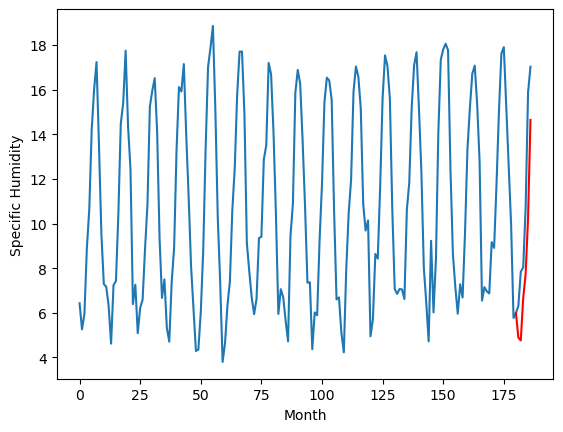

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.34		4.40		0.06
4.53		4.27		-0.26
6.06		6.17		0.11
6.42		7.25		0.83
9.34		9.76		0.42
13.32		14.16		0.84
[180, 181, 182, 183, 184, 185, 186]
[4.15, 4.39862339168787, 4.274559333622456, 6.166024997532368, 7.247554853260517, 9.76402552396059, 14.158319785892964]


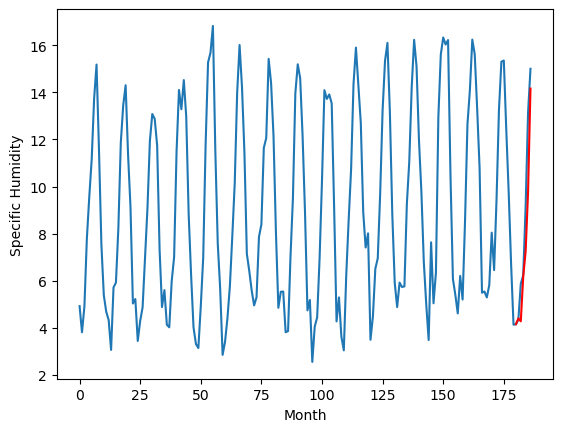

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.22		3.15		-0.07
3.22		3.02		-0.20
5.84		4.92		-0.92
5.55		6.00		0.45
8.39		8.51		0.12
12.91		12.91		-0.00
[180, 181, 182, 183, 184, 185, 186]
[5.12, 3.1486224231123923, 3.024560302197933, 4.916026919782162, 5.997557729184628, 8.514026492536068, 12.908322184979916]


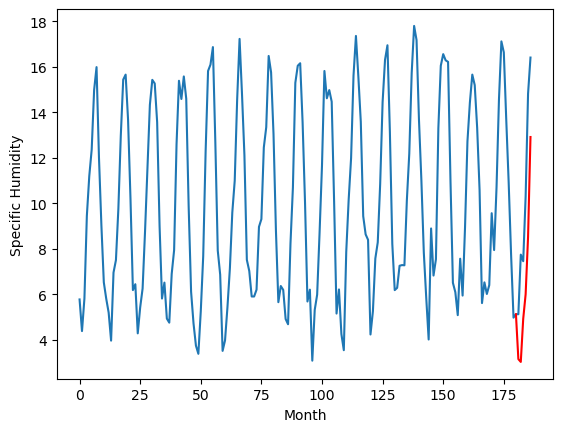

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.03		2.45		0.42
2.10		2.32		0.22
4.74		4.22		-0.52
6.08		5.30		-0.78
9.97		7.81		-2.16
13.16		12.21		-0.95
[180, 181, 182, 183, 184, 185, 186]
[6.35, 2.4486224231123925, 2.3245598179101945, 4.216025481820107, 5.297556291222572, 7.814025054574013, 12.208320747017861]


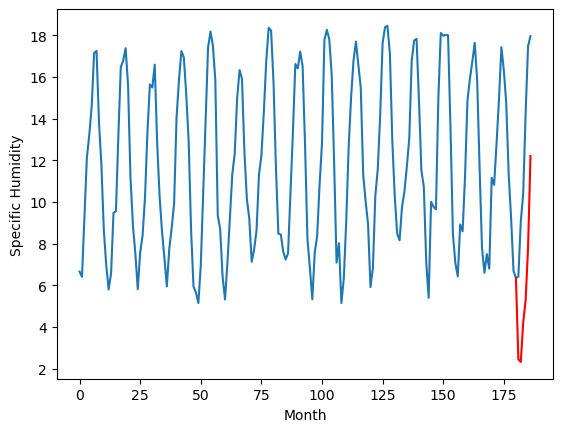

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.18		6.51		0.33
6.22		6.38		0.16
8.94		8.28		-0.66
10.20		9.36		-0.84
14.23		11.87		-2.36
17.64		16.27		-1.37
[180, 181, 182, 183, 184, 185, 186]
[6.08, 6.508622423112392, 6.384560302197933, 8.276025966107845, 9.35755677551031, 11.874025538861751, 16.2683212313056]


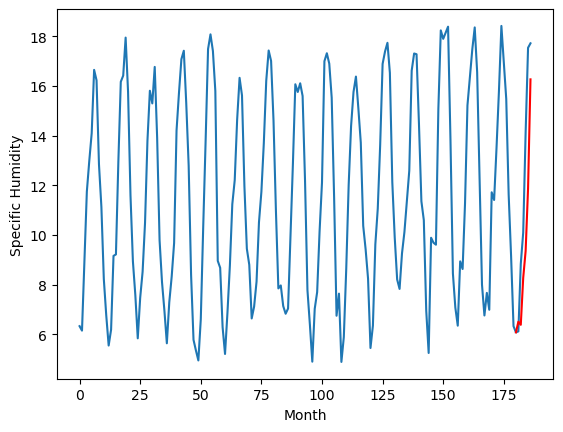

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.75		5.00		-0.75
5.12		4.87		-0.25
5.91		6.77		0.86
7.21		7.85		0.64
11.52		10.36		-1.16
13.69		14.76		1.07
[180, 181, 182, 183, 184, 185, 186]
[3.92, 4.998620493412018, 4.874558849334717, 6.766024513244629, 7.847554368972778, 10.364023132324219, 14.758316440582275]


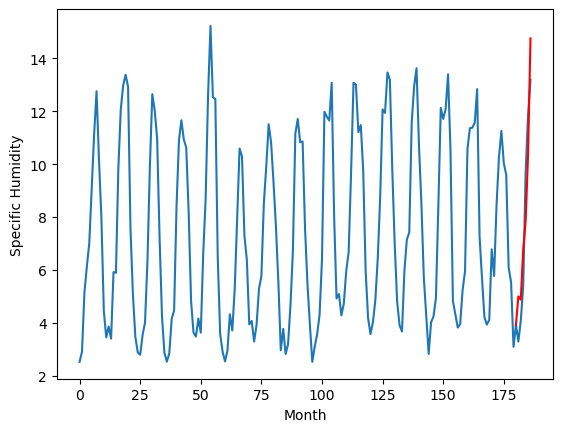

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.66		5.85		0.19
5.78		5.72		-0.06
7.34		7.62		0.28
7.96		8.70		0.74
10.89		11.21		0.32
15.24		15.61		0.37
[180, 181, 182, 183, 184, 185, 186]
[4.16, 5.848624360263347, 5.724561755061149, 7.616027418971061, 8.697556321024894, 11.214026038050651, 15.608321730494499]


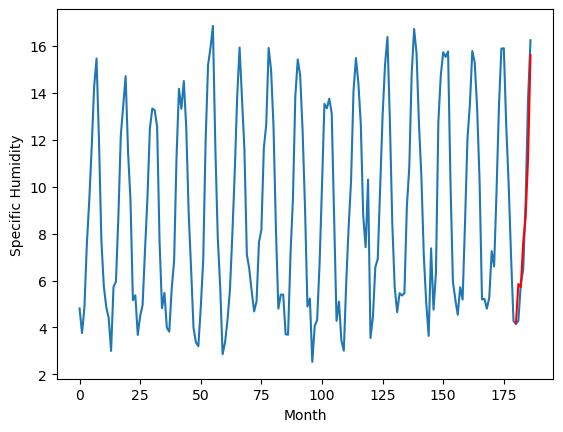

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.53		6.74		0.21
6.01		6.61		0.60
8.74		8.51		-0.23
9.97		9.59		-0.38
13.18		12.10		-1.08
17.94		16.50		-1.44
[180, 181, 182, 183, 184, 185, 186]
[3.84, 6.738622423112393, 6.614559333622456, 8.506024997532368, 9.587555806934834, 12.104024570286274, 16.49832026273012]


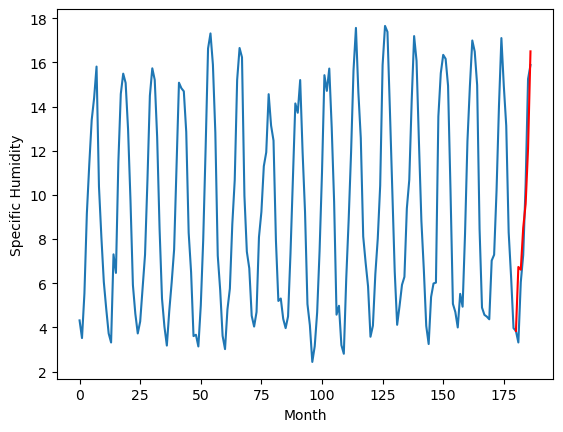

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.49		6.41		-0.08
5.68		6.28		0.60
8.29		8.18		-0.11
9.45		9.26		-0.19
13.67		11.77		-1.90
16.81		16.17		-0.64
[180, 181, 182, 183, 184, 185, 186]
[3.73, 6.408621454536915, 6.284559810459614, 8.176026428043842, 9.257557237446308, 11.774024808704853, 16.168319070637224]


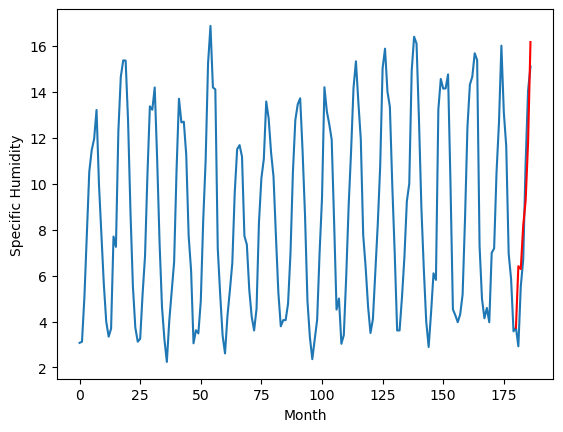

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.71		2.60		-0.11
1.97		2.47		0.50
3.79		4.37		0.58
3.96		5.45		1.49
9.11		7.96		-1.15
12.10		12.36		0.26
[180, 181, 182, 183, 184, 185, 186]
[2.83, 2.598621454536915, 2.4745593336224556, 4.366024997532367, 5.447554853260517, 7.964022424519062, 12.35831811696291]


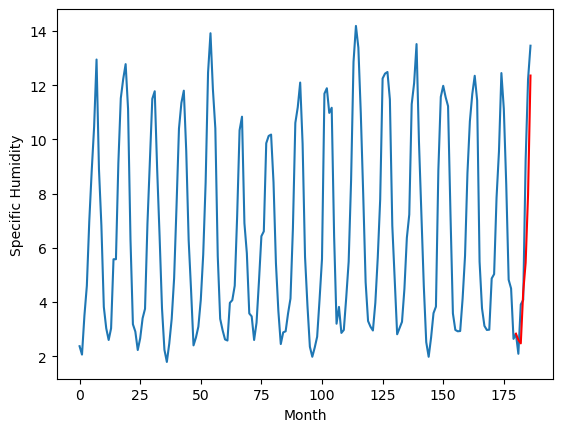

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.08		4.89		0.81
4.12		4.76		0.64
5.36		6.66		1.30
6.73		7.74		1.01
8.26		10.25		1.99
13.58		14.65		1.07
[180, 181, 182, 183, 184, 185, 186]
[2.69, 4.888624360263347, 4.764561755061149, 6.6560302799940105, 7.737558228373527, 10.2540288990736, 14.64832125365734]


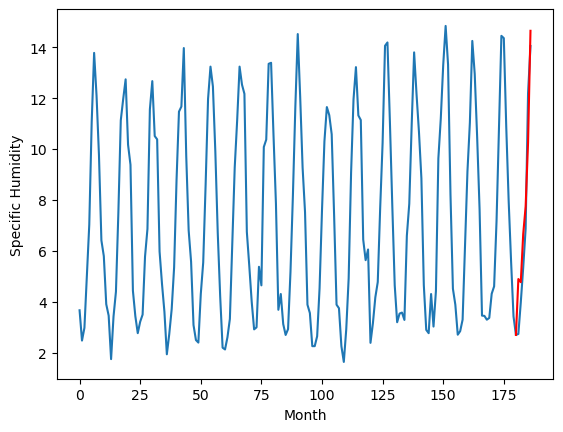

RangeIndex(start=1, stop=12, step=1)
[5.03, 4.340000000000002, 3.2199999999999998, 2.0299999999999994, 6.18, 5.75, 5.66, 6.529999999999999, 6.49, 2.7100000000000004, 4.079999999999999]
[4.888622423112392, 4.39862339168787, 3.1486224231123923, 2.4486224231123925, 6.508622423112392, 4.998620493412018, 5.848624360263347, 6.738622423112393, 6.408621454536915, 2.598621454536915, 4.888624360263347]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    5.03   4.888622
1                 1    4.34   4.398623
2                 2    3.22   3.148622
3                 3    2.03   2.448622
4                 4    6.18   6.508622
5                 5    5.75   4.998620
6                 6    5.66   5.848624
7                 7    6.53   6.738622
8                 8    6.49   6.408621
9                 9    2.71   2.598621
10               10    4.08   4.888624


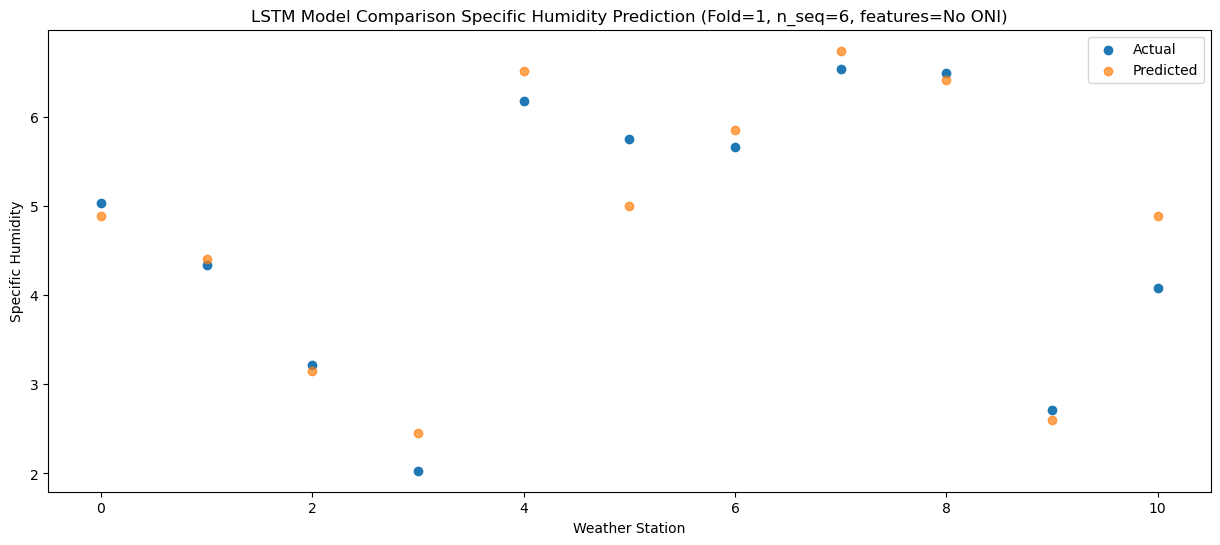

Predictions for (t+1):
    Weather_Station  Actual  Predicted
0                 0    5.35   4.764560
1                 1    4.53   4.274559
2                 2    3.22   3.024560
3                 3    2.10   2.324560
4                 4    6.22   6.384560
5                 5    5.12   4.874559
6                 6    5.78   5.724562
7                 7    6.01   6.614559
8                 8    5.68   6.284560
9                 9    1.97   2.474559
10               10    4.12   4.764562


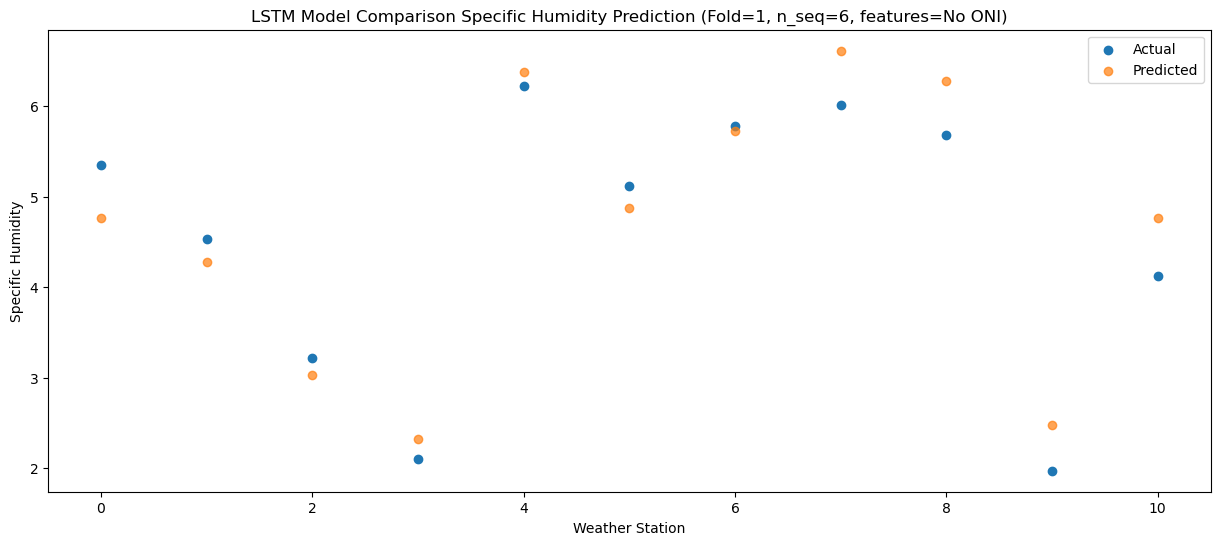

Predictions for (t+2):
    Weather_Station  Actual  Predicted
0                 0    6.88   6.656025
1                 1    6.06   6.166025
2                 2    5.84   4.916027
3                 3    4.74   4.216025
4                 4    8.94   8.276026
5                 5    5.91   6.766025
6                 6    7.34   7.616027
7                 7    8.74   8.506025
8                 8    8.29   8.176026
9                 9    3.79   4.366025
10               10    5.36   6.656030


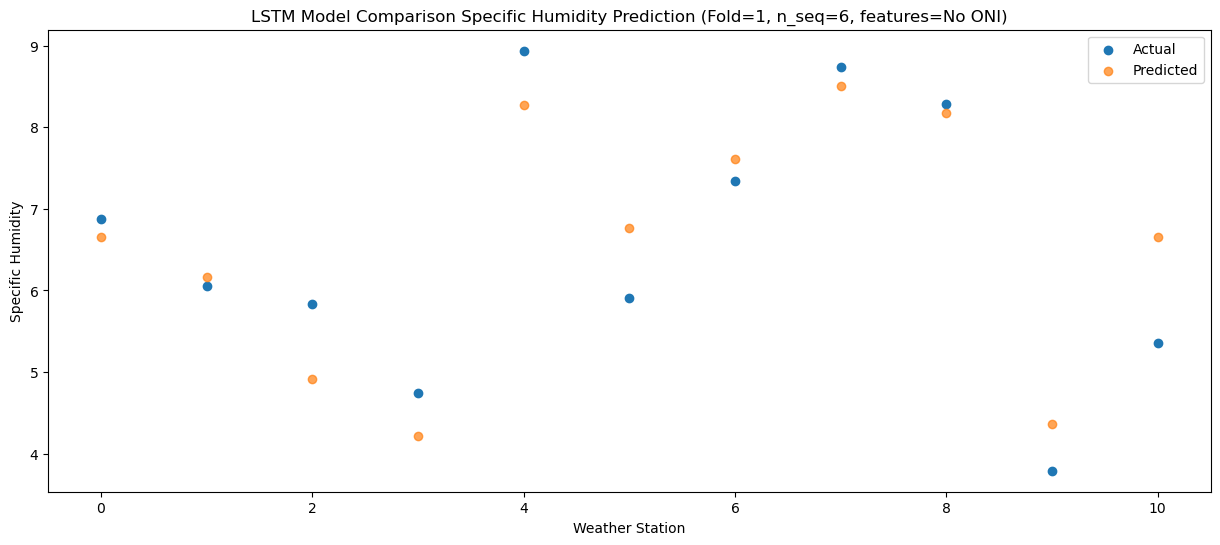

Predictions for (t+3):
    Weather_Station  Actual  Predicted
0                 0    7.08   7.737555
1                 1    6.42   7.247555
2                 2    5.55   5.997558
3                 3    6.08   5.297556
4                 4   10.20   9.357557
5                 5    7.21   7.847554
6                 6    7.96   8.697556
7                 7    9.97   9.587556
8                 8    9.45   9.257557
9                 9    3.96   5.447555
10               10    6.73   7.737558


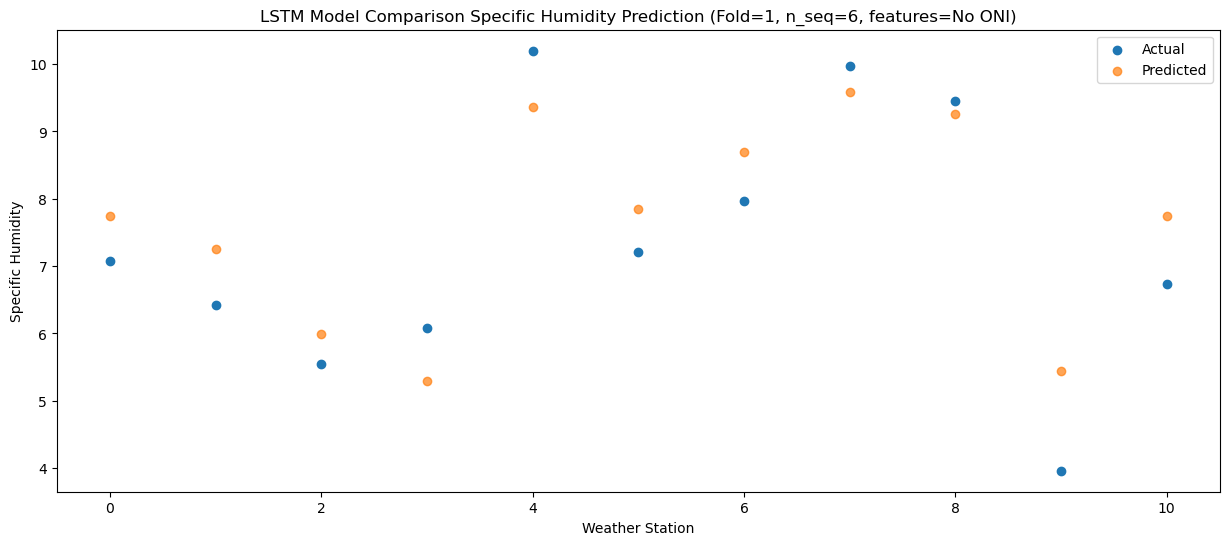

Predictions for (t+4):
    Weather_Station  Actual  Predicted
0                 0    9.76  10.254026
1                 1    9.34   9.764026
2                 2    8.39   8.514026
3                 3    9.97   7.814025
4                 4   14.23  11.874026
5                 5   11.52  10.364023
6                 6   10.89  11.214026
7                 7   13.18  12.104025
8                 8   13.67  11.774025
9                 9    9.11   7.964022
10               10    8.26  10.254029


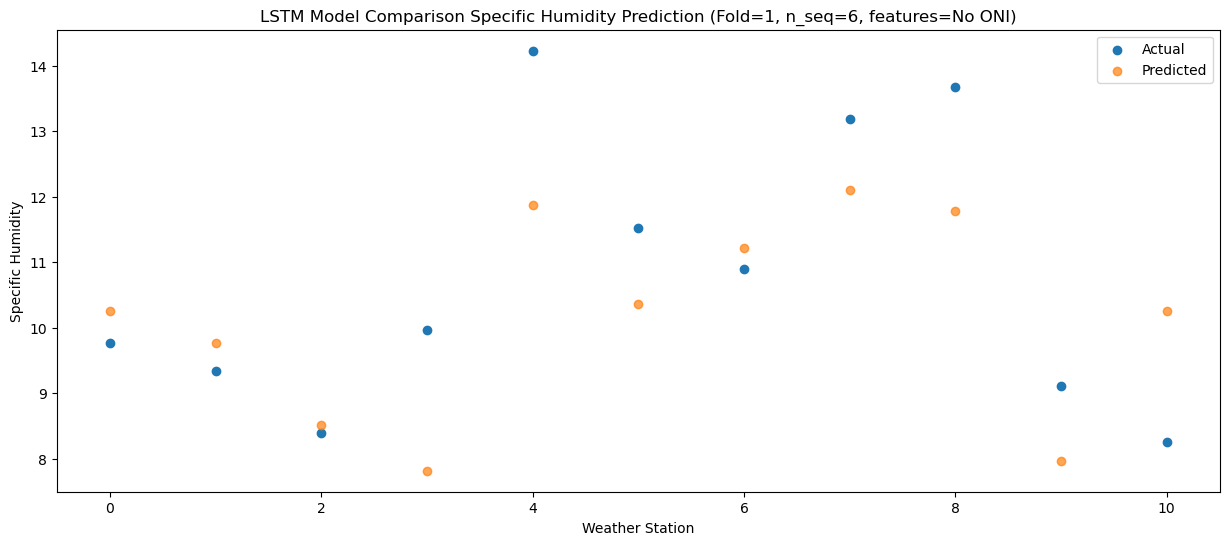

Predictions for (t+5):
    Weather_Station  Actual  Predicted
0                 0   14.92  14.648320
1                 1   13.32  14.158320
2                 2   12.91  12.908322
3                 3   13.16  12.208321
4                 4   17.64  16.268321
5                 5   13.69  14.758316
6                 6   15.24  15.608322
7                 7   17.94  16.498320
8                 8   16.81  16.168319
9                 9   12.10  12.358318
10               10   13.58  14.648321


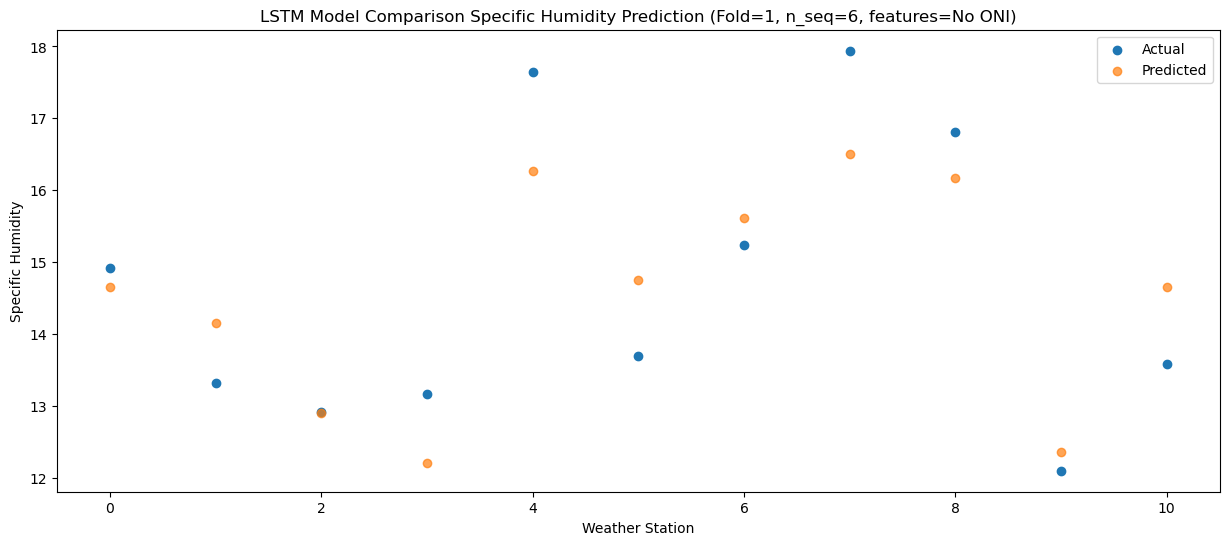

Model: "sequential_501"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1002 (LSTM)            (1, 1, 256)               2279424   
                                                                 
 dropout_1002 (Dropout)      (1, 1, 256)               0         
                                                                 
 lstm_1003 (LSTM)            (1, 256)                  525312    
                                                                 
 dropout_1003 (Dropout)      (1, 256)                  0         
                                                                 
 dense_1503 (Dense)          (1, 256)                  65792     
                                                                 
 dense_1504 (Dense)          (1, 128)                  32896     
                                                                 
 dense_1505 (Dense)          (1, 6)                 

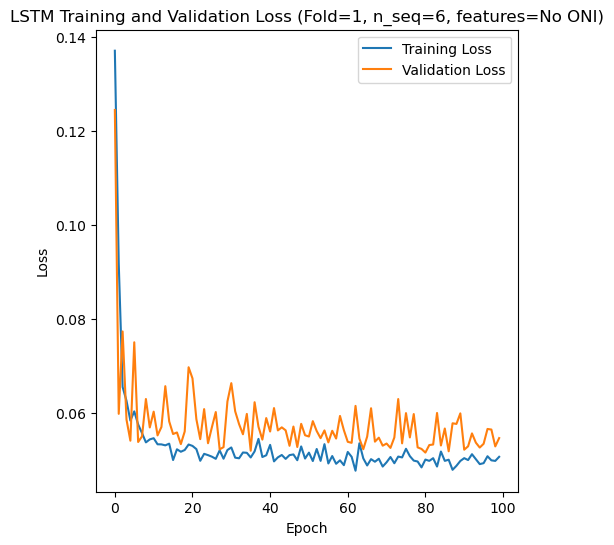

Epoch 1/100
84/84 [==============================] - 42s 297ms/step - loss: 0.1363 - val_loss: 0.0661
Epoch 2/100
84/84 [==============================] - 17s 199ms/step - loss: 0.0859 - val_loss: 0.0293
Epoch 3/100
84/84 [==============================] - 17s 197ms/step - loss: 0.0694 - val_loss: 0.0456
Epoch 4/100
84/84 [==============================] - 16s 187ms/step - loss: 0.0600 - val_loss: 0.0387
Epoch 5/100
84/84 [==============================] - 15s 175ms/step - loss: 0.0628 - val_loss: 0.0321
Epoch 6/100
84/84 [==============================] - 13s 159ms/step - loss: 0.0609 - val_loss: 0.0354
Epoch 7/100
84/84 [==============================] - 14s 162ms/step - loss: 0.0573 - val_loss: 0.0611
Epoch 8/100
84/84 [==============================] - 15s 179ms/step - loss: 0.0552 - val_loss: 0.0549
Epoch 9/100
84/84 [==============================] - 17s 199ms/step - loss: 0.0537 - val_loss: 0.0353
Epoch 10/100
84/84 [==============================] - 17s 207ms/step - loss: 0.054

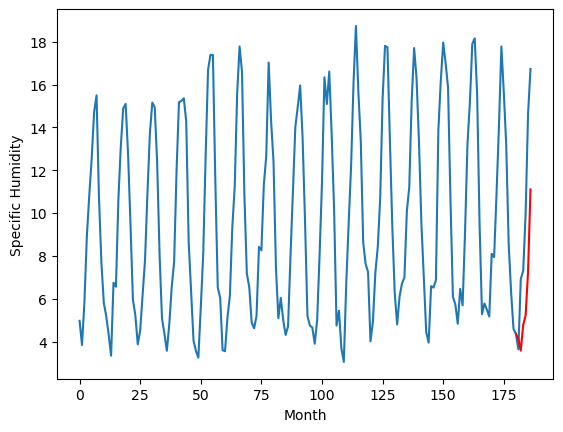

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
1.84		1.40		-0.44
1.16		0.85		-0.31
3.01		2.04		-0.97
3.13		2.50		-0.63
8.25		4.53		-3.72
11.16		8.38		-2.78
[180, 181, 182, 183, 184, 185, 186]
[2.82, 1.4000949108600615, 0.8455404484272002, 2.043778344392776, 2.4955001914501187, 4.530513867139816, 8.376276358366013]


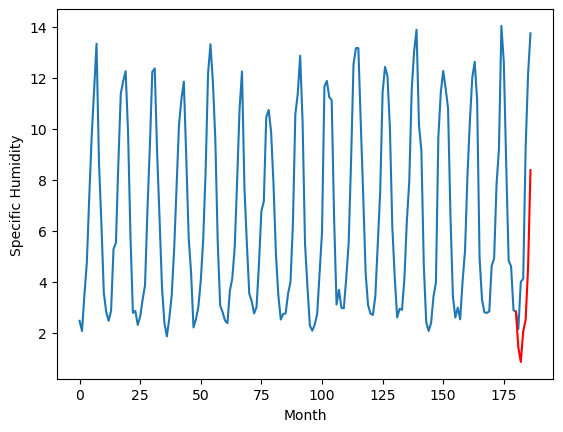

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.53		4.55		-0.98
7.66		4.00		-3.66
7.88		5.19		-2.69
8.85		5.65		-3.20
10.16		7.68		-2.48
13.94		11.53		-2.41
[180, 181, 182, 183, 184, 185, 186]
[9.16, 4.550095864534378, 3.9955414021015168, 5.1937783443927765, 5.645499237775803, 7.680513867139816, 11.526273497343063]


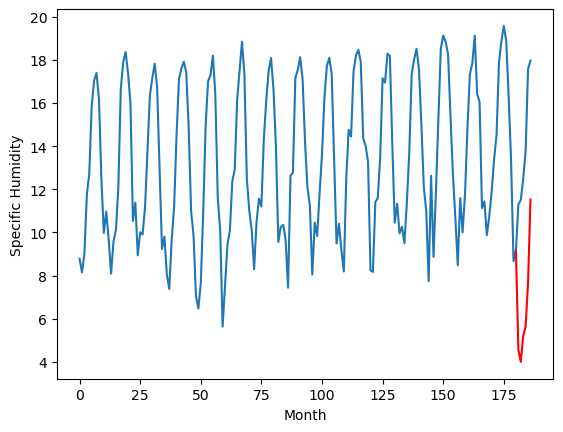

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.98		4.57		0.59
4.15		4.02		-0.13
4.79		5.21		0.42
6.14		5.67		-0.47
7.82		7.70		-0.12
12.42		11.55		-0.87
[180, 181, 182, 183, 184, 185, 186]
[2.44, 4.570094910860061, 4.0155404484272, 5.213776437044143, 5.665499237775802, 7.700511959791183, 11.546272543668746]


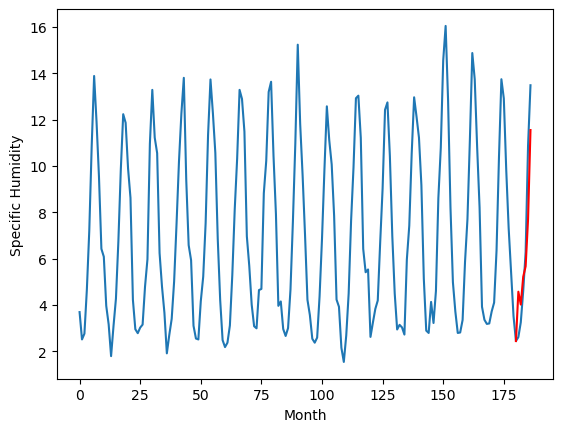

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.10		4.48		-0.62
5.08		3.93		-1.15
8.37		5.12		-3.25
8.39		5.58		-2.81
11.59		7.61		-3.98
15.48		11.46		-4.02
[180, 181, 182, 183, 184, 185, 186]
[6.65, 4.480096341371536, 3.9255409252643583, 5.123779774904251, 5.575498760938644, 7.610510529279709, 11.456269205808638]


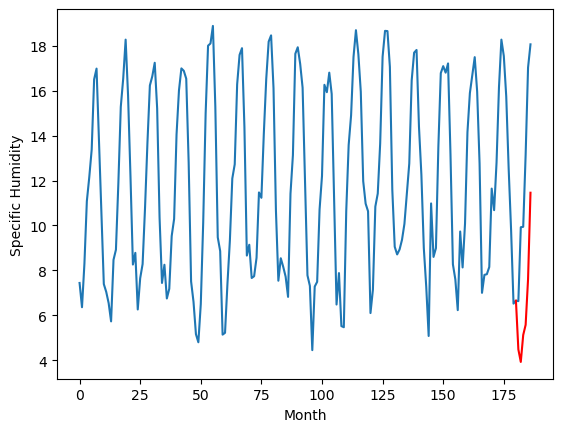

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.33		1.97		-0.36
2.28		1.42		-0.86
5.27		2.61		-2.66
6.84		3.07		-3.77
11.67		5.10		-6.57
14.31		8.95		-5.36
[180, 181, 182, 183, 184, 185, 186]
[6.19, 1.970095864534378, 1.4155414021015167, 2.6137812054157257, 3.0655011451244354, 5.100514820814133, 8.94627445101738]


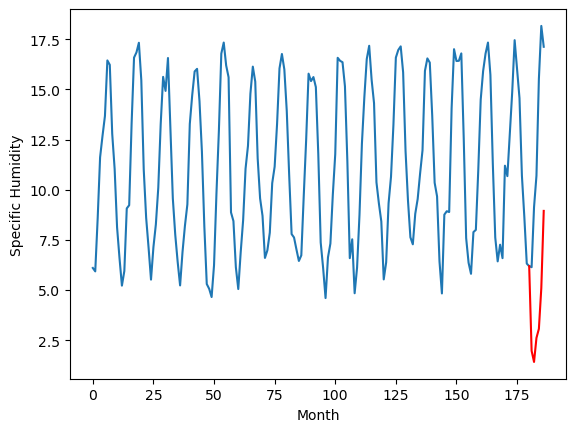

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.68		8.29		-0.39
8.35		7.74		-0.61
11.21		8.93		-2.28
12.53		9.39		-3.14
16.73		11.42		-5.31
20.48		15.27		-5.21
[180, 181, 182, 183, 184, 185, 186]
[4.78, 8.290096341371536, 7.735541878938674, 8.933781682252883, 9.38550257563591, 11.420516251325607, 15.266274927854537]


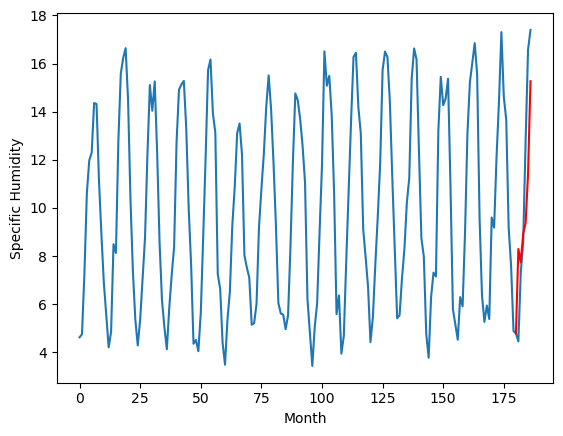

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.97		3.20		-0.77
3.84		2.65		-1.19
3.93		3.84		-0.09
4.23		4.30		0.07
4.35		6.33		1.98
7.01		10.18		3.17
[180, 181, 182, 183, 184, 185, 186]
[2.61, 3.2000944340229034, 2.645539971590042, 3.843776913881302, 4.295498760938644, 6.330512436628341, 10.176273974180221]


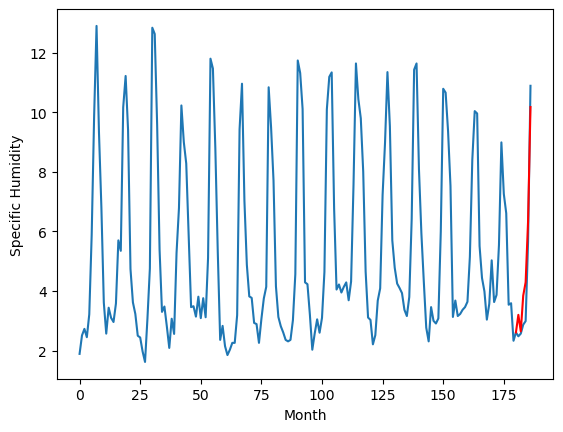

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.29		6.95		-1.34
8.82		6.40		-2.42
8.93		7.59		-1.34
10.25		8.05		-2.20
11.73		10.08		-1.65
12.98		13.93		0.95
[180, 181, 182, 183, 184, 185, 186]
[4.6, 6.950096341371537, 6.3955423557758335, 7.593778344392777, 8.045502098798753, 10.08051577448845, 13.92627731204033]


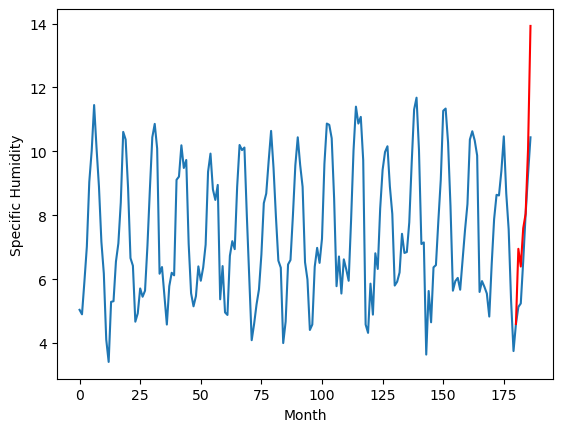

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.98		5.61		-0.37
6.05		5.06		-0.99
7.78		6.25		-1.53
8.31		6.71		-1.60
11.02		8.74		-2.28
15.52		12.59		-2.93
[180, 181, 182, 183, 184, 185, 186]
[4.27, 5.610096341371536, 5.055541402101516, 6.253781205415725, 6.705501145124435, 8.740514820814132, 12.58627445101738]


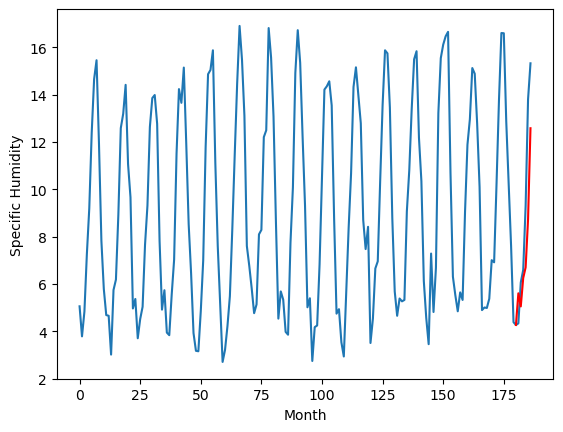

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.63		4.13		-0.50
4.87		3.58		-1.29
5.90		4.77		-1.13
6.51		5.23		-1.28
9.18		7.26		-1.92
13.28		11.11		-2.17
[180, 181, 182, 183, 184, 185, 186]
[3.91, 4.13009538769722, 3.5755409252643586, 4.773779774904251, 5.225499714612961, 7.260513390302658, 11.106273020505906]


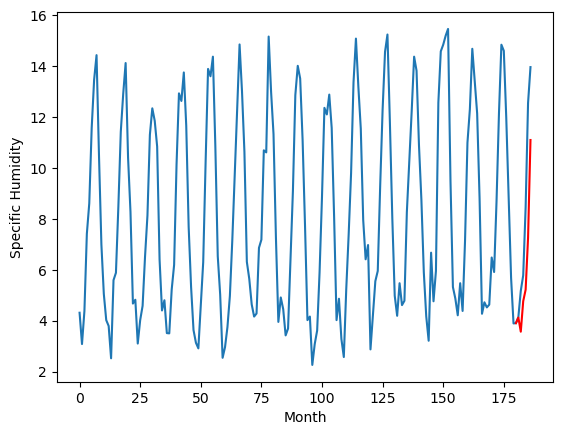

RangeIndex(start=1, stop=12, step=1)
[4.390000000000001, 1.8399999999999992, 5.529999999999999, 3.9799999999999995, 5.1, 2.33, 8.68, 3.9700000000000006, 8.29, 5.9799999999999995, 4.63]
[4.130095864534378, 1.4000949108600615, 4.550095864534378, 4.570094910860061, 4.480096341371536, 1.970095864534378, 8.290096341371536, 3.2000944340229034, 6.950096341371537, 5.610096341371536, 4.13009538769722]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    4.39   4.130096
1                 1    1.84   1.400095
2                 2    5.53   4.550096
3                 3    3.98   4.570095
4                 4    5.10   4.480096
5                 5    2.33   1.970096
6                 6    8.68   8.290096
7                 7    3.97   3.200094
8                 8    8.29   6.950096
9                 9    5.98   5.610096
10               10    4.63   4.130095


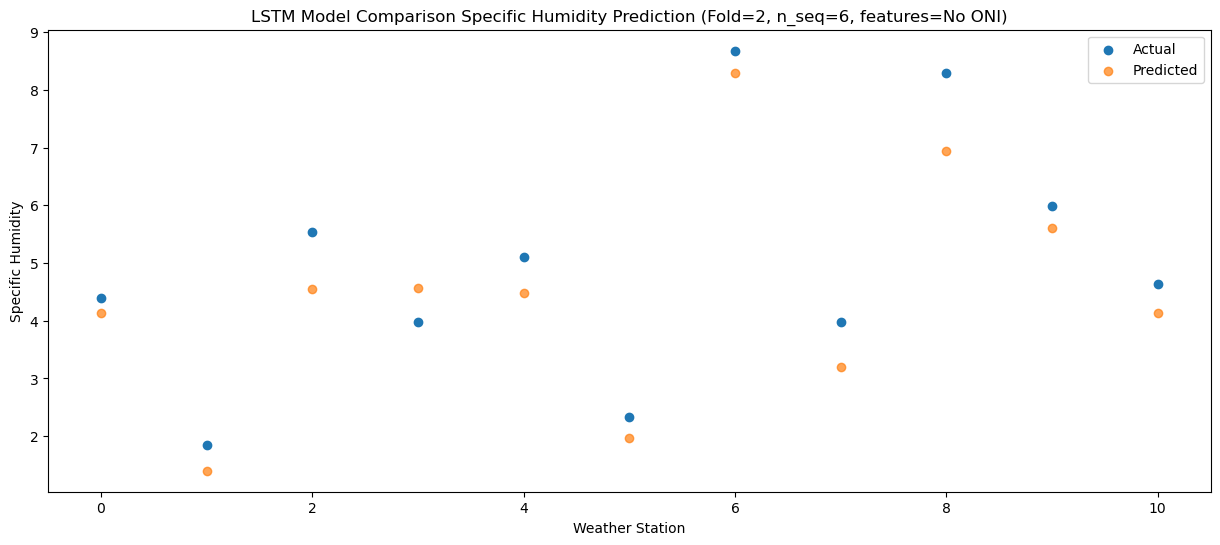

Predictions for (t+1):
    Weather_Station  Actual  Predicted
0                 0    3.67   3.575541
1                 1    1.16   0.845540
2                 2    7.66   3.995541
3                 3    4.15   4.015540
4                 4    5.08   3.925541
5                 5    2.28   1.415541
6                 6    8.35   7.735542
7                 7    3.84   2.645540
8                 8    8.82   6.395542
9                 9    6.05   5.055541
10               10    4.87   3.575541


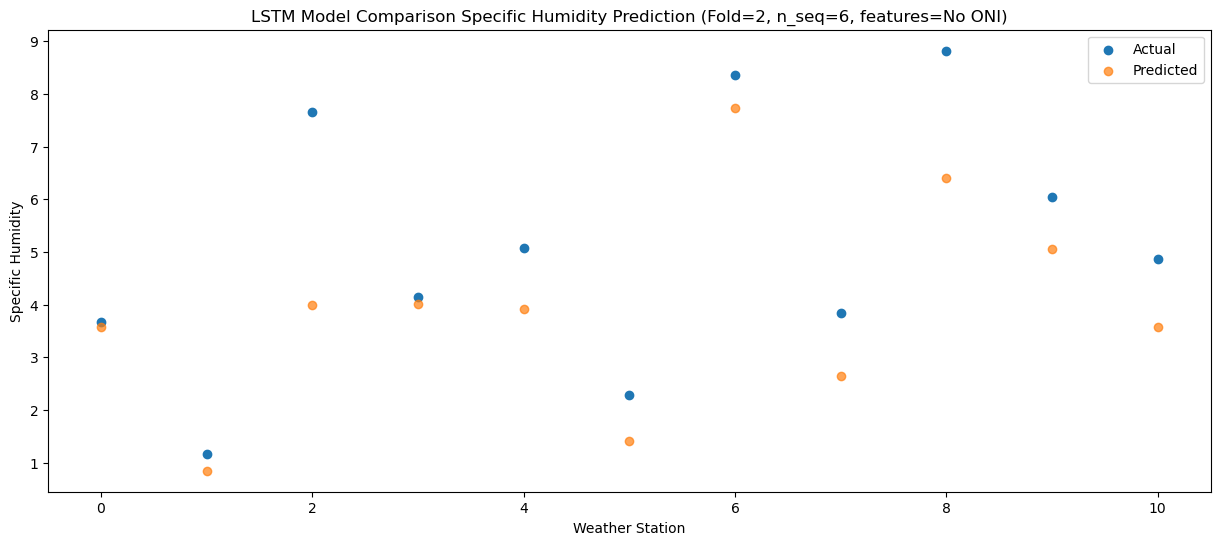

Predictions for (t+2):
    Weather_Station  Actual  Predicted
0                 0    6.95   4.773780
1                 1    3.01   2.043778
2                 2    7.88   5.193778
3                 3    4.79   5.213776
4                 4    8.37   5.123780
5                 5    5.27   2.613781
6                 6   11.21   8.933782
7                 7    3.93   3.843777
8                 8    8.93   7.593778
9                 9    7.78   6.253781
10               10    5.90   4.773780


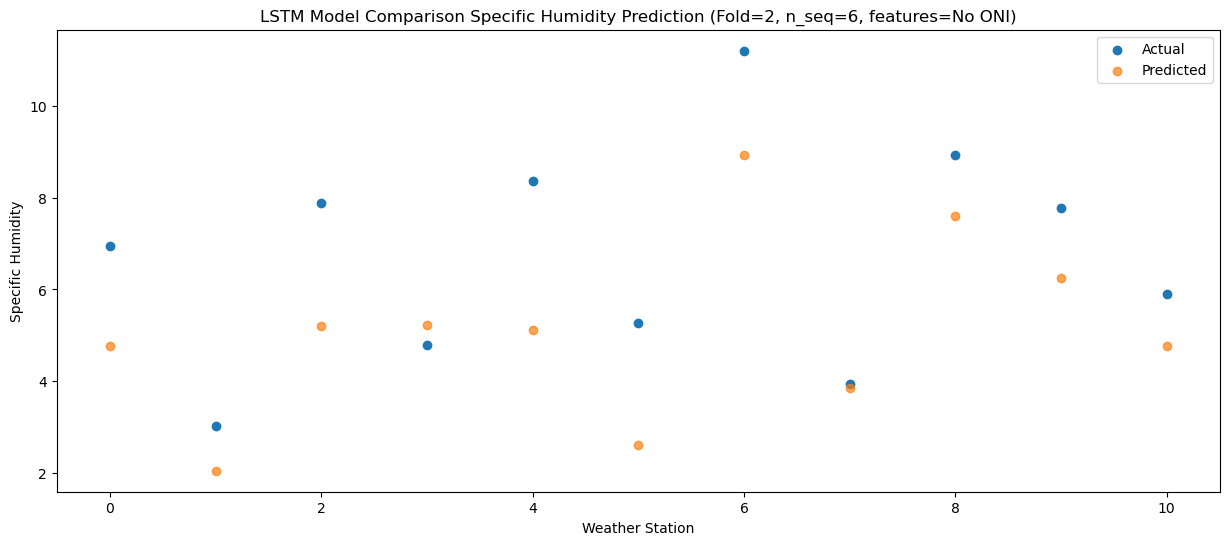

Predictions for (t+3):
    Weather_Station  Actual  Predicted
0                 0    7.34   5.225501
1                 1    3.13   2.495500
2                 2    8.85   5.645499
3                 3    6.14   5.665499
4                 4    8.39   5.575499
5                 5    6.84   3.065501
6                 6   12.53   9.385503
7                 7    4.23   4.295499
8                 8   10.25   8.045502
9                 9    8.31   6.705501
10               10    6.51   5.225500


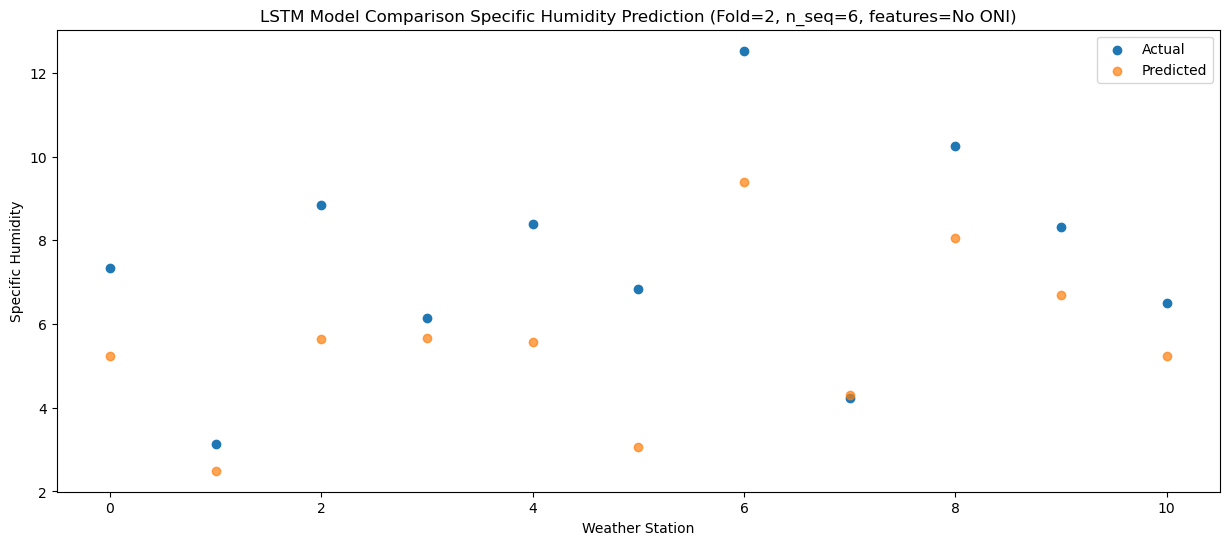

Predictions for (t+4):
    Weather_Station  Actual  Predicted
0                 0   10.01   7.260513
1                 1    8.25   4.530514
2                 2   10.16   7.680514
3                 3    7.82   7.700512
4                 4   11.59   7.610511
5                 5   11.67   5.100515
6                 6   16.73  11.420516
7                 7    4.35   6.330512
8                 8   11.73  10.080516
9                 9   11.02   8.740515
10               10    9.18   7.260513


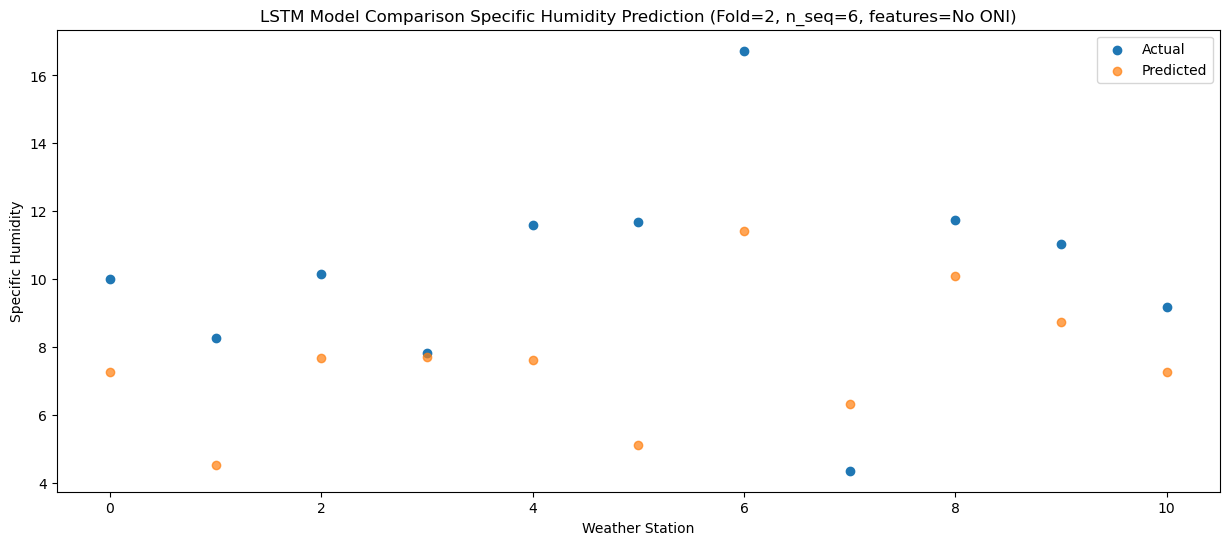

Predictions for (t+5):
    Weather_Station  Actual  Predicted
0                 0   14.66  11.106272
1                 1   11.16   8.376276
2                 2   13.94  11.526273
3                 3   12.42  11.546273
4                 4   15.48  11.456269
5                 5   14.31   8.946274
6                 6   20.48  15.266275
7                 7    7.01  10.176274
8                 8   12.98  13.926277
9                 9   15.52  12.586274
10               10   13.28  11.106273


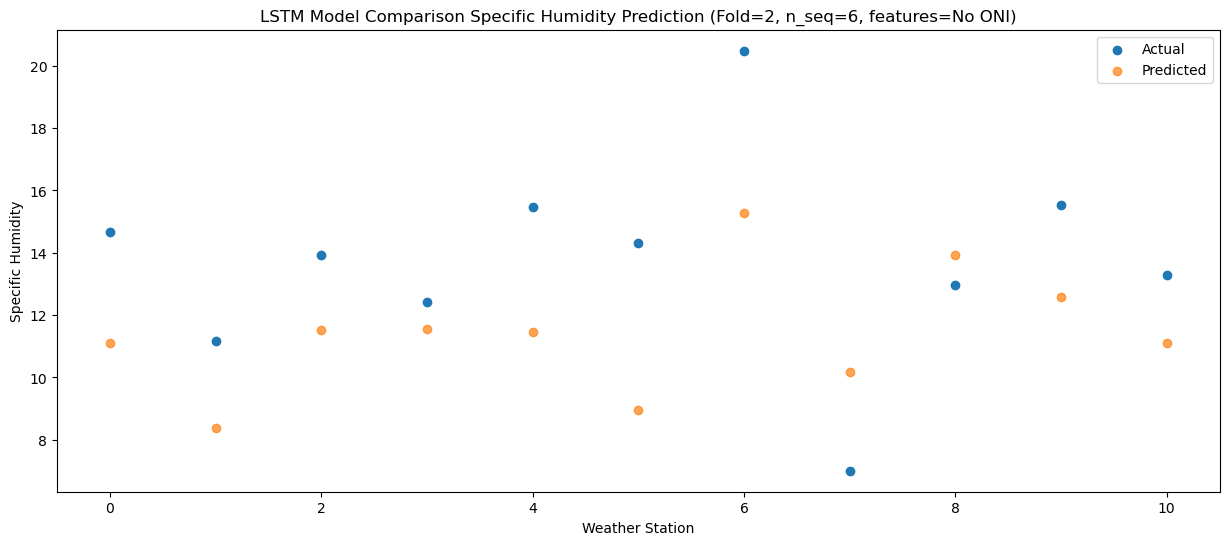

Model: "sequential_502"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1004 (LSTM)            (1, 1, 256)               2279424   
                                                                 
 dropout_1004 (Dropout)      (1, 1, 256)               0         
                                                                 
 lstm_1005 (LSTM)            (1, 256)                  525312    
                                                                 
 dropout_1005 (Dropout)      (1, 256)                  0         
                                                                 
 dense_1506 (Dense)          (1, 256)                  65792     
                                                                 
 dense_1507 (Dense)          (1, 128)                  32896     
                                                                 
 dense_1508 (Dense)          (1, 6)                 

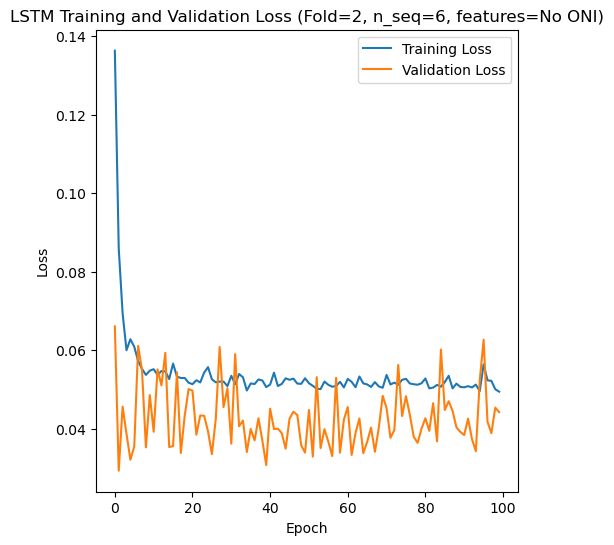

Epoch 1/100
84/84 [==============================] - 41s 272ms/step - loss: 0.1272 - val_loss: 0.0741
Epoch 2/100
84/84 [==============================] - 15s 182ms/step - loss: 0.0763 - val_loss: 0.0628
Epoch 3/100
84/84 [==============================] - 17s 205ms/step - loss: 0.0693 - val_loss: 0.0576
Epoch 4/100
84/84 [==============================] - 16s 192ms/step - loss: 0.0564 - val_loss: 0.0503
Epoch 5/100
84/84 [==============================] - 16s 194ms/step - loss: 0.0571 - val_loss: 0.0738
Epoch 6/100
84/84 [==============================] - 18s 216ms/step - loss: 0.0579 - val_loss: 0.0693
Epoch 7/100
84/84 [==============================] - 20s 240ms/step - loss: 0.0544 - val_loss: 0.0582
Epoch 8/100
84/84 [==============================] - 21s 245ms/step - loss: 0.0543 - val_loss: 0.0564
Epoch 9/100
84/84 [==============================] - 20s 236ms/step - loss: 0.0524 - val_loss: 0.0636
Epoch 10/100
84/84 [==============================] - 20s 240ms/step - loss: 0.053

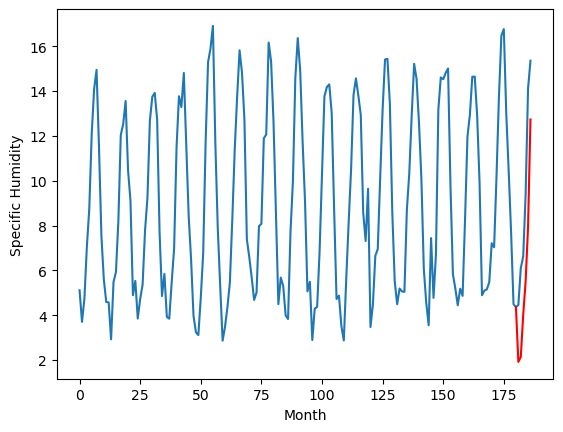

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.64		2.95		0.31
2.08		3.17		1.09
4.59		5.05		0.46
5.76		6.55		0.79
9.28		8.98		-0.30
13.81		13.78		-0.03
[180, 181, 182, 183, 184, 185, 186]
[3.43, 2.9525954234600067, 3.1741244900226593, 5.053709279298783, 6.553465615510941, 8.98322225689888, 13.775768529176712]


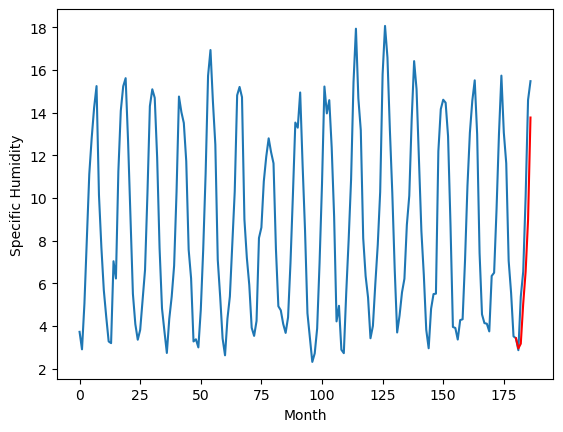

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.37		6.15		-0.22
6.31		6.37		0.06
6.39		8.25		1.86
7.01		9.75		2.74
7.41		12.18		4.77
9.86		16.98		7.12
[180, 181, 182, 183, 184, 185, 186]
[5.43, 6.152593501210212, 6.374122567772865, 8.253707357048988, 9.753463693261146, 12.183222241997719, 16.975769467949867]


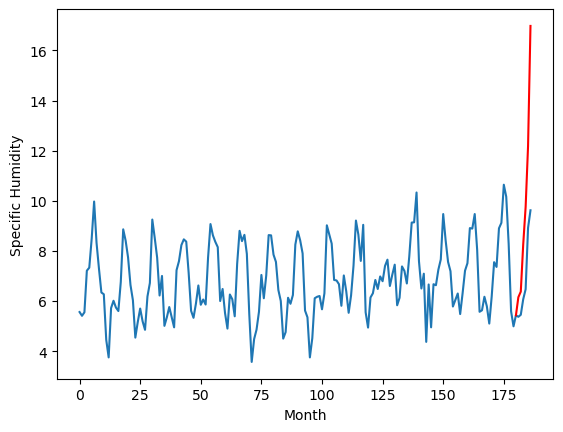

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.44		3.93		0.49
3.37		4.15		0.78
4.67		6.03		1.36
5.86		7.53		1.67
8.39		9.96		1.57
13.81		14.76		0.95
[180, 181, 182, 183, 184, 185, 186]
[3.21, 3.9325963920354843, 4.154125458598137, 6.03371024787426, 7.533468491435051, 9.963223940730096, 14.755771166682244]


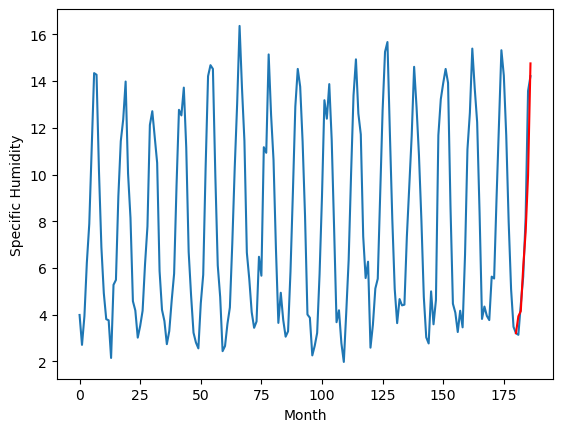

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.91		5.33		0.42
4.08		5.55		1.47
6.56		7.43		0.87
7.62		8.93		1.31
10.04		11.36		1.32
14.50		16.16		1.66
[180, 181, 182, 183, 184, 185, 186]
[3.04, 5.332595423460007, 5.55412449002266, 7.433709279298783, 8.93346561551094, 11.36322225689888, 16.155767575502395]


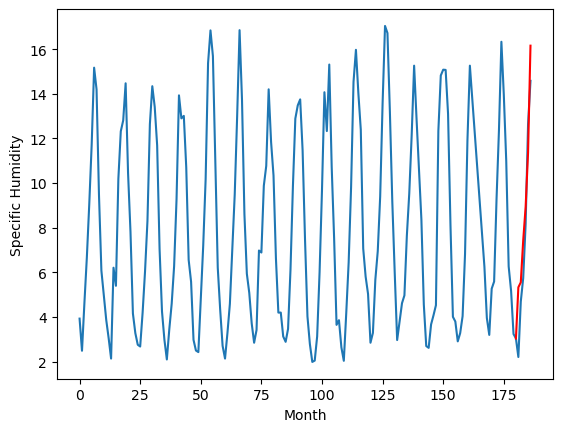

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.42		3.95		0.53
2.90		4.17		1.27
4.93		6.05		1.12
6.23		7.55		1.32
8.47		9.98		1.51
13.69		14.78		1.09
[180, 181, 182, 183, 184, 185, 186]
[2.91, 3.9525963920354843, 4.174125458598137, 6.05371024787426, 7.553467537760735, 9.983224179148674, 14.775770451426506]


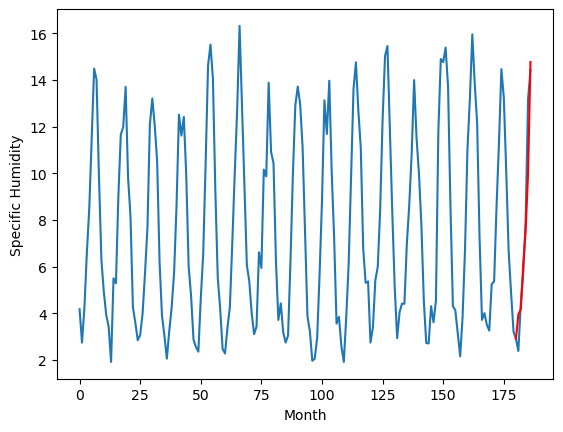

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.73		5.78		0.05
5.79		6.00		0.21
6.10		7.88		1.78
6.57		9.38		2.81
7.97		11.81		3.84
9.30		16.61		7.31
[180, 181, 182, 183, 184, 185, 186]
[1.6, 5.782594454884529, 6.004125443696975, 7.8837083256244656, 9.38346561551094, 11.813221064805983, 16.60576829075813]


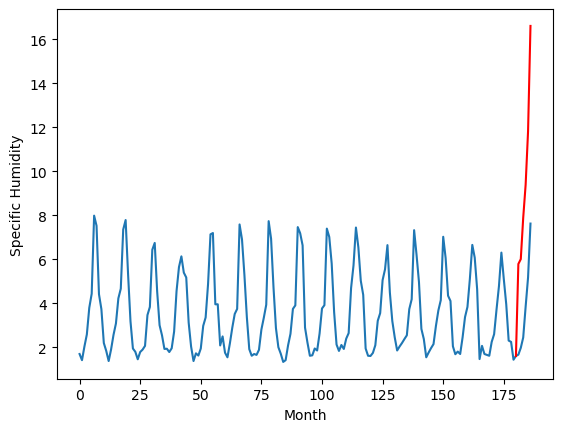

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.80		4.21		-0.59
4.32		4.43		0.11
4.62		6.31		1.69
4.31		7.81		3.50
4.87		10.24		5.37
6.29		15.04		8.75
[180, 181, 182, 183, 184, 185, 186]
[2.86, 4.212593501210213, 4.4341225677728655, 6.313708310723305, 7.813464646935463, 10.243222241997719, 15.0357713752985]


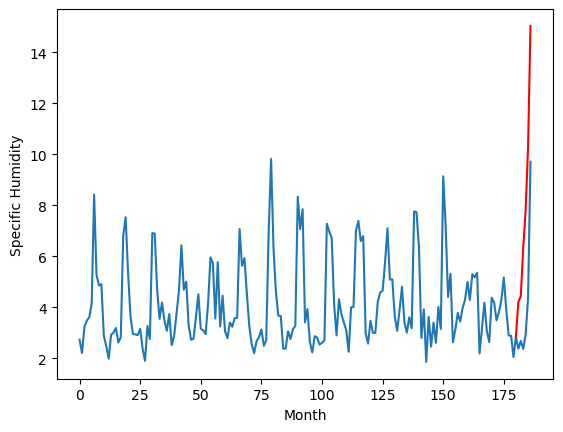

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.60		4.15		-0.45
4.25		4.37		0.12
3.90		6.25		2.35
4.83		7.75		2.92
5.27		10.18		4.91
6.70		14.98		8.28
[180, 181, 182, 183, 184, 185, 186]
[5.65, 4.152593501210212, 4.374123536348343, 6.253709279298782, 7.753464661836624, 10.18322225689888, 14.975769482851028]


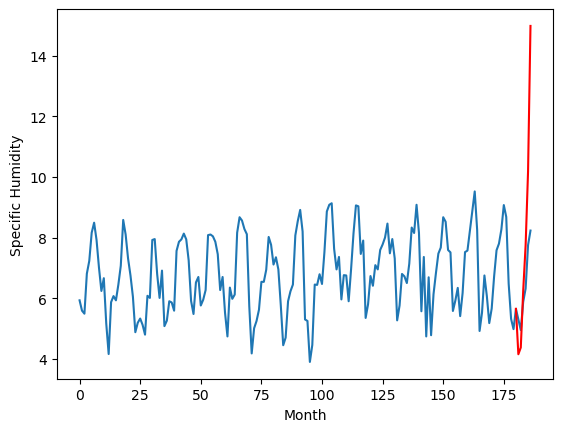

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.09		4.40		1.31
3.24		4.62		1.38
4.02		6.50		2.48
5.40		8.00		2.60
6.97		10.43		3.46
11.87		15.23		3.36
[180, 181, 182, 183, 184, 185, 186]
[2.54, 4.402596392035484, 4.624125458598137, 6.50371024787426, 8.00346849143505, 10.43322513282299, 15.225772358775139]


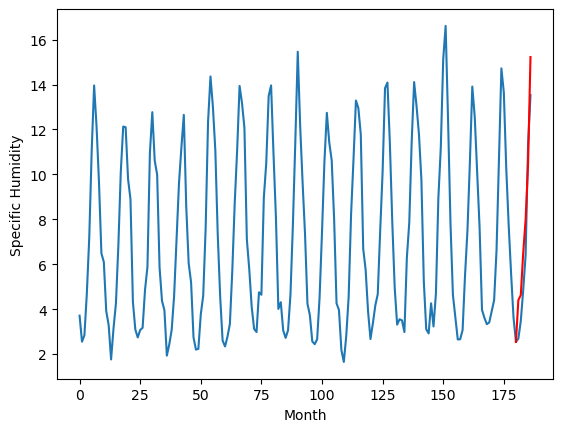

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
1.00		1.91		0.91
0.86		2.13		1.27
2.14		4.01		1.87
3.55		5.51		1.96
5.14		7.94		2.80
10.01		12.74		2.73
[180, 181, 182, 183, 184, 185, 186]
[2.51, 1.9125954234600067, 2.1341244900226592, 4.013709279298782, 5.5134665691852565, 7.943223210573196, 12.735772343873977]


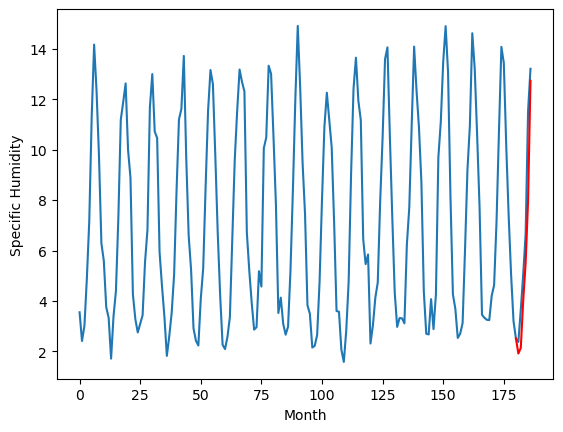

RangeIndex(start=1, stop=12, step=1)
[1.5600000000000005, 2.64, 6.369999999999998, 3.4399999999999995, 4.91, 3.42, 5.73, 4.800000000000001, 4.6, 3.09, 0.9999999999999993]
[1.9125973606109619, 2.9525954234600067, 6.152593501210212, 3.9325963920354843, 5.332595423460007, 3.9525963920354843, 5.782594454884529, 4.212593501210213, 4.152593501210212, 4.402596392035484, 1.9125954234600067]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    1.56   1.912597
1                 1    2.64   2.952595
2                 2    6.37   6.152594
3                 3    3.44   3.932596
4                 4    4.91   5.332595
5                 5    3.42   3.952596
6                 6    5.73   5.782594
7                 7    4.80   4.212594
8                 8    4.60   4.152594
9                 9    3.09   4.402596
10               10    1.00   1.912595


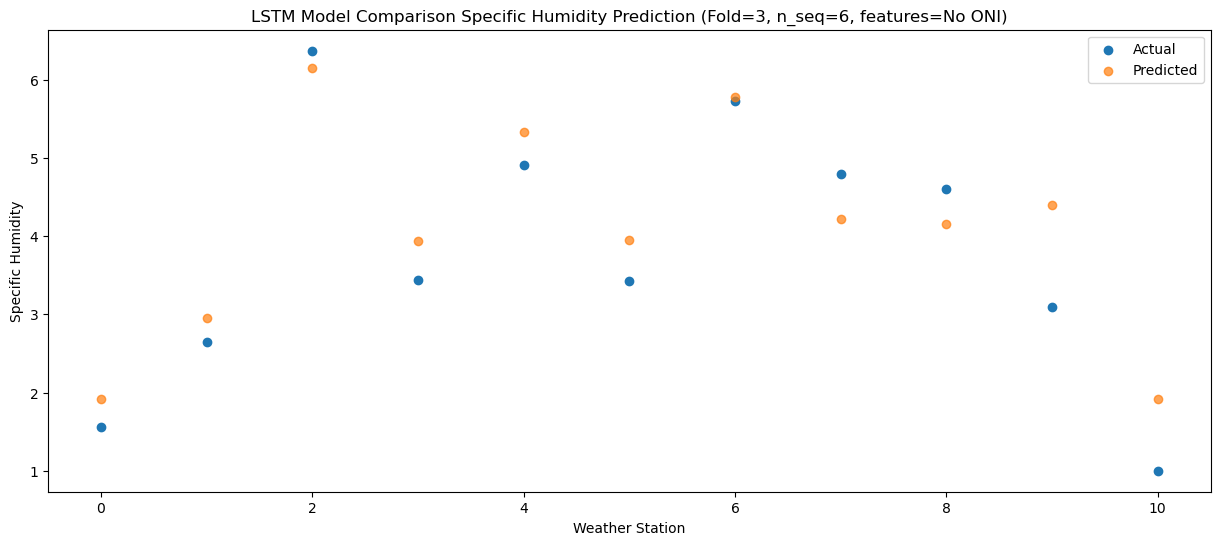

Predictions for (t+1):
    Weather_Station  Actual  Predicted
0                 0    1.65   2.134126
1                 1    2.08   3.174124
2                 2    6.31   6.374123
3                 3    3.37   4.154125
4                 4    4.08   5.554124
5                 5    2.90   4.174125
6                 6    5.79   6.004125
7                 7    4.32   4.434123
8                 8    4.25   4.374124
9                 9    3.24   4.624125
10               10    0.86   2.134124


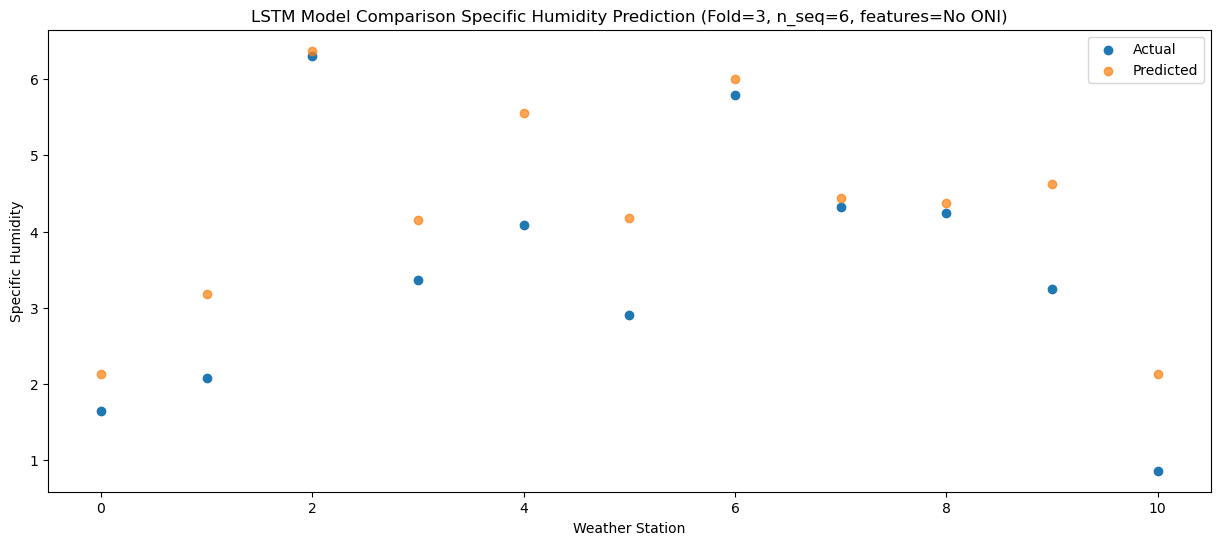

Predictions for (t+2):
    Weather_Station  Actual  Predicted
0                 0    3.30   4.013711
1                 1    4.59   5.053709
2                 2    6.39   8.253707
3                 3    4.67   6.033710
4                 4    6.56   7.433709
5                 5    4.93   6.053710
6                 6    6.10   7.883708
7                 7    4.62   6.313708
8                 8    3.90   6.253709
9                 9    4.02   6.503710
10               10    2.14   4.013709


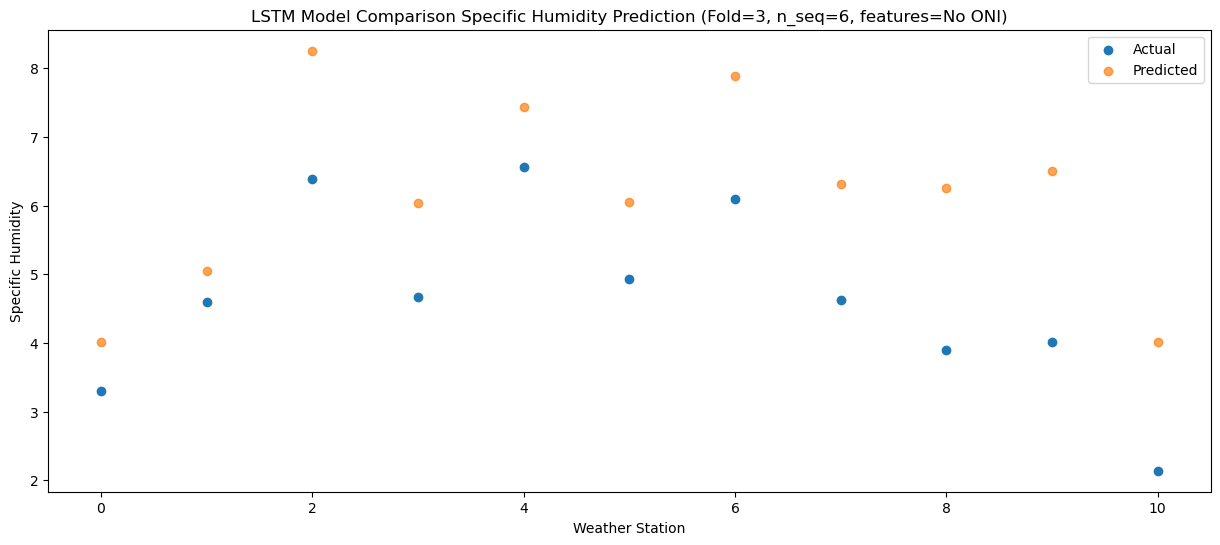

Predictions for (t+3):
    Weather_Station  Actual  Predicted
0                 0    3.82   5.513469
1                 1    5.76   6.553466
2                 2    7.01   9.753464
3                 3    5.86   7.533468
4                 4    7.62   8.933466
5                 5    6.23   7.553468
6                 6    6.57   9.383466
7                 7    4.31   7.813465
8                 8    4.83   7.753465
9                 9    5.40   8.003468
10               10    3.55   5.513467


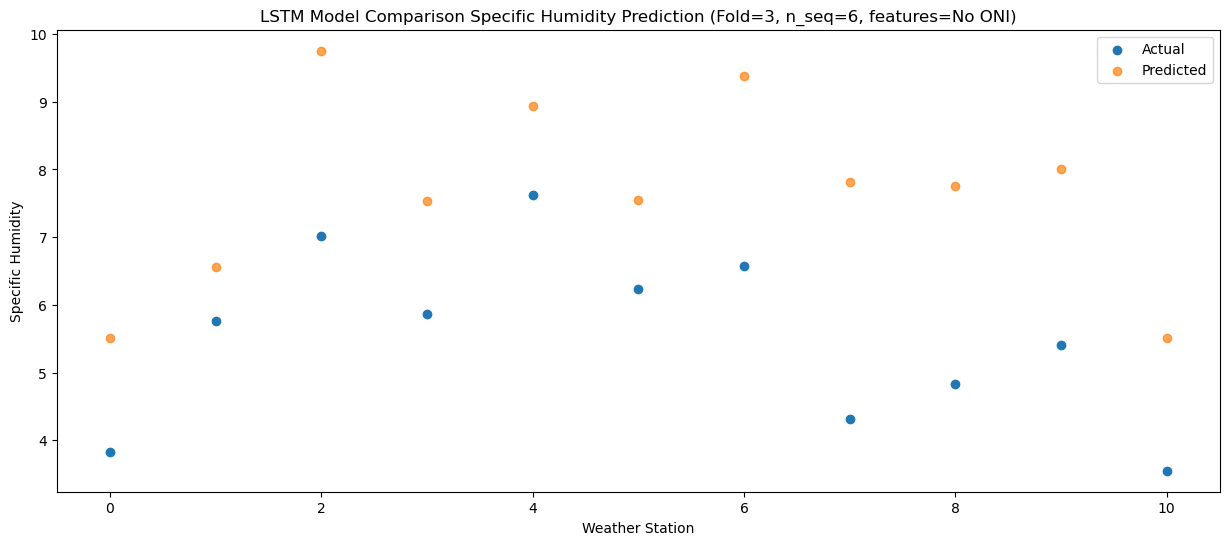

Predictions for (t+4):
    Weather_Station  Actual  Predicted
0                 0    6.60   7.943225
1                 1    9.28   8.983222
2                 2    7.41  12.183222
3                 3    8.39   9.963224
4                 4   10.04  11.363222
5                 5    8.47   9.983224
6                 6    7.97  11.813221
7                 7    4.87  10.243222
8                 8    5.27  10.183222
9                 9    6.97  10.433225
10               10    5.14   7.943223


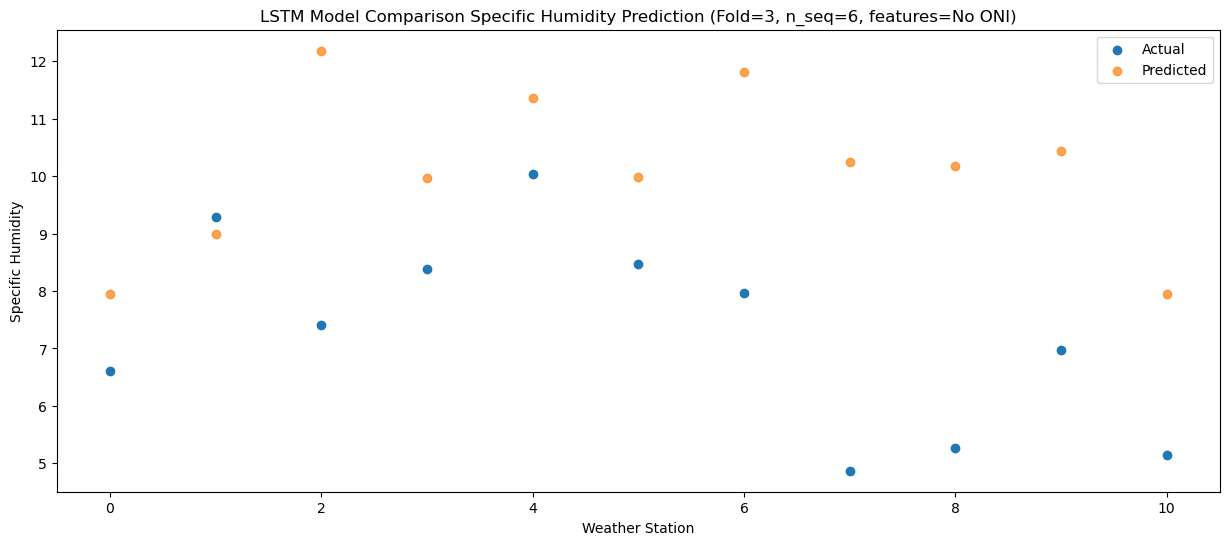

Predictions for (t+5):
    Weather_Station  Actual  Predicted
0                 0   11.32  12.735772
1                 1   13.81  13.775769
2                 2    9.86  16.975769
3                 3   13.81  14.755771
4                 4   14.50  16.155768
5                 5   13.69  14.775770
6                 6    9.30  16.605768
7                 7    6.29  15.035771
8                 8    6.70  14.975769
9                 9   11.87  15.225772
10               10   10.01  12.735772


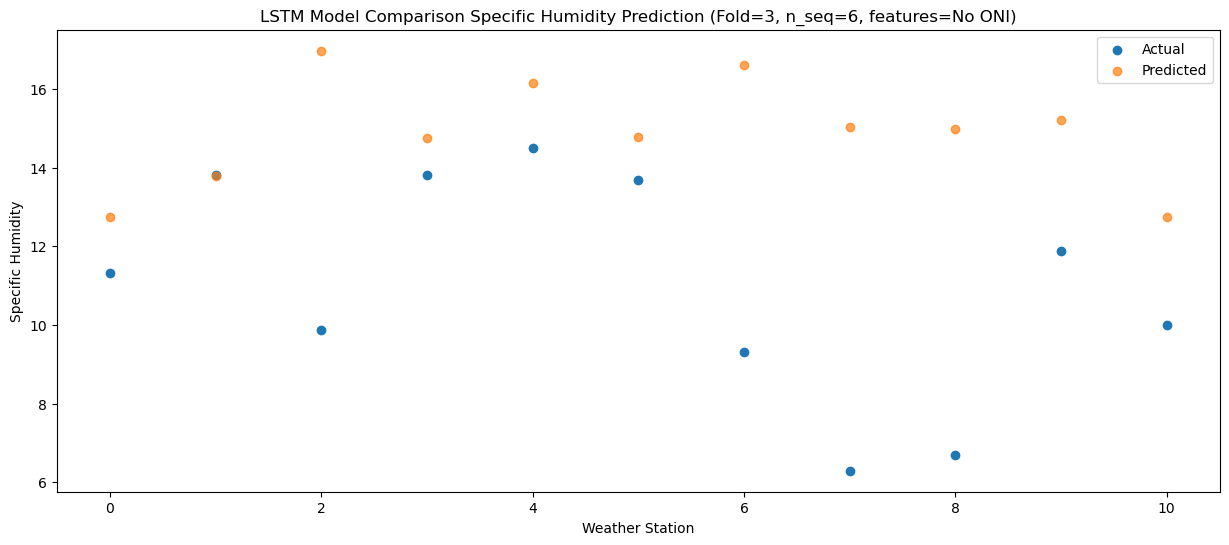

Model: "sequential_503"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1006 (LSTM)            (1, 1, 256)               2279424   
                                                                 
 dropout_1006 (Dropout)      (1, 1, 256)               0         
                                                                 
 lstm_1007 (LSTM)            (1, 256)                  525312    
                                                                 
 dropout_1007 (Dropout)      (1, 256)                  0         
                                                                 
 dense_1509 (Dense)          (1, 256)                  65792     
                                                                 
 dense_1510 (Dense)          (1, 128)                  32896     
                                                                 
 dense_1511 (Dense)          (1, 6)                 

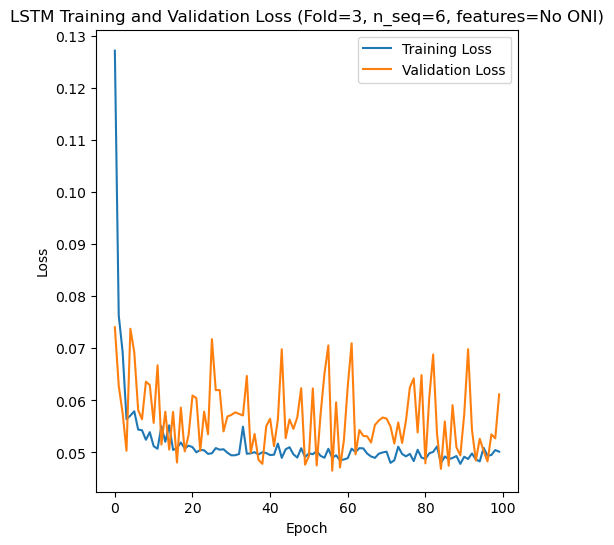

Epoch 1/100
84/84 [==============================] - 38s 279ms/step - loss: 0.1307 - val_loss: 0.0892
Epoch 2/100
84/84 [==============================] - 19s 222ms/step - loss: 0.0820 - val_loss: 0.0753
Epoch 3/100
84/84 [==============================] - 18s 208ms/step - loss: 0.0690 - val_loss: 0.0650
Epoch 4/100
84/84 [==============================] - 17s 205ms/step - loss: 0.0635 - val_loss: 0.0519
Epoch 5/100
84/84 [==============================] - 19s 230ms/step - loss: 0.0610 - val_loss: 0.0677
Epoch 6/100
84/84 [==============================] - 20s 238ms/step - loss: 0.0580 - val_loss: 0.0444
Epoch 7/100
84/84 [==============================] - 19s 229ms/step - loss: 0.0556 - val_loss: 0.0520
Epoch 8/100
84/84 [==============================] - 19s 232ms/step - loss: 0.0561 - val_loss: 0.0589
Epoch 9/100
84/84 [==============================] - 20s 235ms/step - loss: 0.0558 - val_loss: 0.0520
Epoch 10/100
84/84 [==============================] - 19s 225ms/step - loss: 0.052

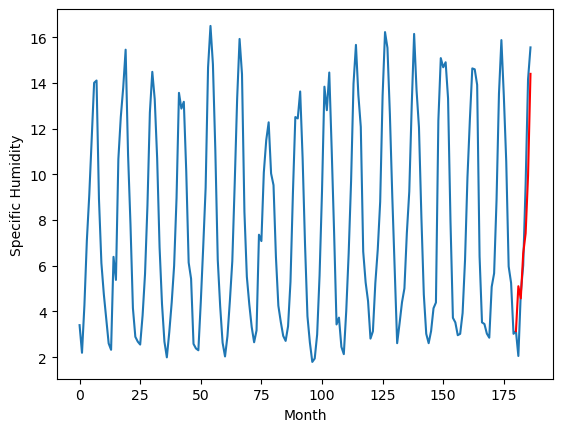

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.27		3.80		-0.47
6.26		3.27		-2.99
6.23		5.24		-0.99
6.98		6.12		-0.86
8.31		8.65		0.34
12.60		13.10		0.50
[180, 181, 182, 183, 184, 185, 186]
[7.79, 3.8039443251490592, 3.2722527143359184, 5.239250576198101, 6.115339135825634, 8.649901246726513, 13.101505136191845]


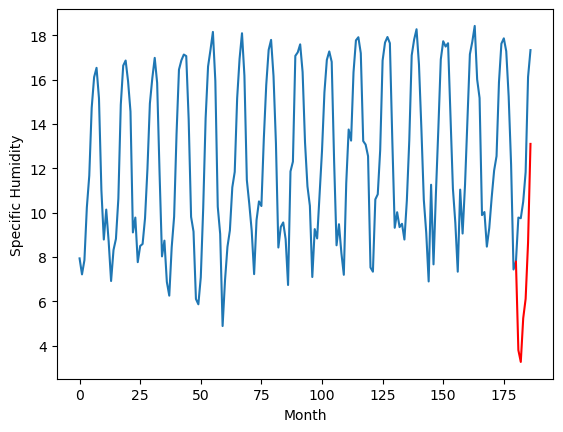

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.87		3.86		-0.01
3.75		3.33		-0.42
6.81		5.30		-1.51
7.06		6.18		-0.88
10.50		8.71		-1.79
14.74		13.16		-1.58
[180, 181, 182, 183, 184, 185, 186]
[5.03, 3.8639530274271965, 3.332262429893017, 5.299265060126782, 6.175357494056225, 8.709917697608471, 13.161520633399487]


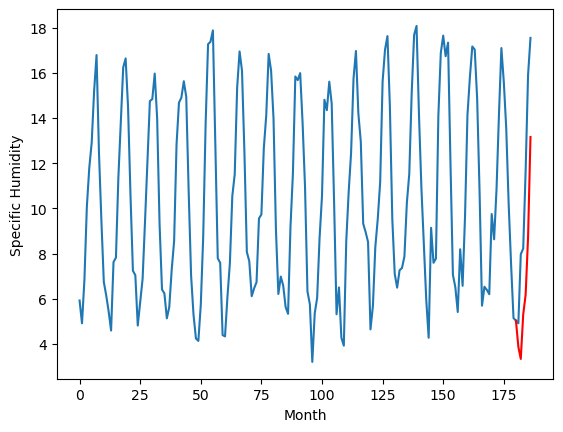

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.73		3.72		-0.01
3.41		3.19		-0.22
6.07		5.16		-0.91
7.36		6.04		-1.32
11.36		8.57		-2.79
15.05		13.02		-2.03
[180, 181, 182, 183, 184, 185, 186]
[4.41, 3.7239530274271964, 3.1922624298930167, 5.159264106452465, 6.035356540381908, 8.569916743934154, 13.021521587073803]


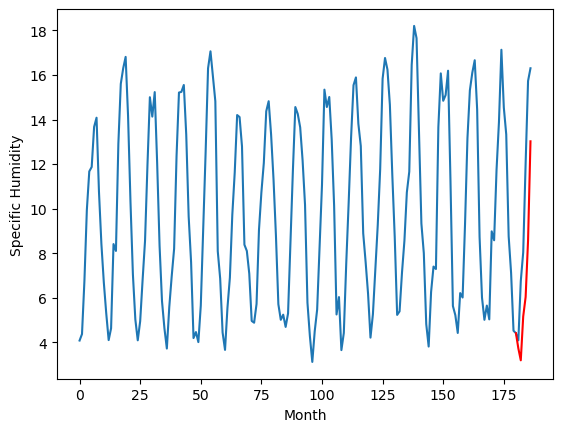

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.36		3.28		-0.08
2.91		2.75		-0.16
5.49		4.72		-0.77
6.85		5.60		-1.25
11.14		8.13		-3.01
15.02		12.58		-2.44
[180, 181, 182, 183, 184, 185, 186]
[4.29, 3.283952058851719, 2.7522599712014197, 4.719260694086552, 5.595353128015995, 8.129913331568241, 12.581517221033574]


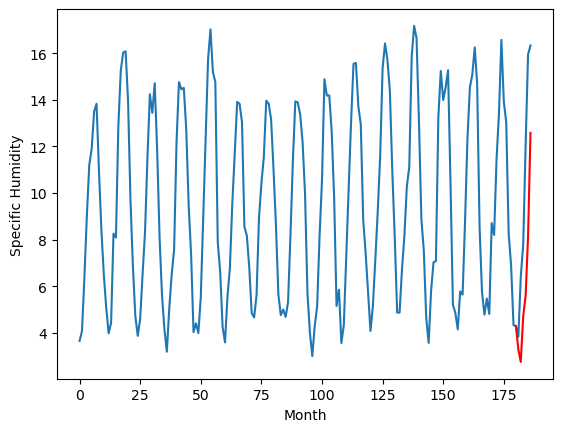

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.64		7.82		-0.82
8.00		7.29		-0.71
9.49		9.26		-0.23
10.45		10.14		-0.31
15.00		12.67		-2.33
17.30		17.12		-0.18
[180, 181, 182, 183, 184, 185, 186]
[3.47, 7.823947223424912, 7.29225710272789, 9.259257825613023, 10.135347338914872, 12.669907542467119, 17.121509524583818]


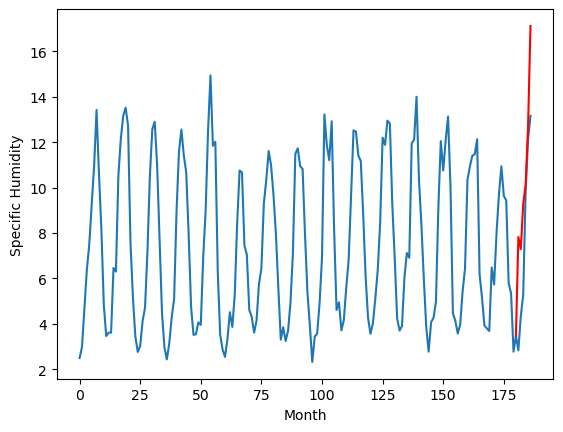

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.80		5.80		0.00
6.05		5.27		-0.78
7.76		7.24		-0.52
8.17		8.12		-0.05
11.15		10.65		-0.50
15.84		15.10		-0.74
[180, 181, 182, 183, 184, 185, 186]
[4.52, 5.803949160575867, 5.272257549762726, 7.239257318973541, 8.115348739624023, 10.649910850524902, 15.101514739990234]


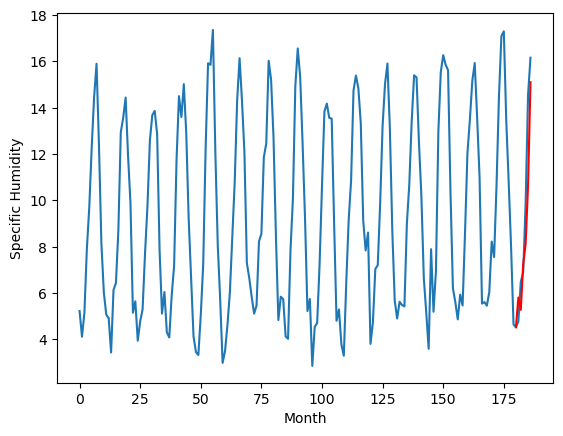

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.93		3.96		0.03
3.30		3.43		0.13
5.67		5.40		-0.27
6.59		6.28		-0.31
9.75		8.81		-0.94
14.35		13.26		-1.09
[180, 181, 182, 183, 184, 185, 186]
[3.4, 3.963952058851719, 3.43225997120142, 5.3992626014351845, 6.275355035364628, 8.809915238916874, 13.261520082056522]


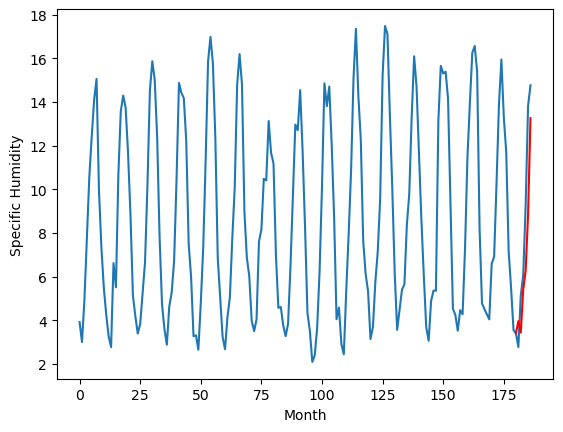

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.30		3.53		0.23
2.73		3.00		0.27
4.67		4.97		0.30
6.00		5.85		-0.15
8.29		8.38		0.09
13.35		12.83		-0.52
[180, 181, 182, 183, 184, 185, 186]
[2.82, 3.5339472234249114, 3.0022561490535735, 4.969255918264389, 5.845346385240555, 8.379908496141434, 12.831510478258133]


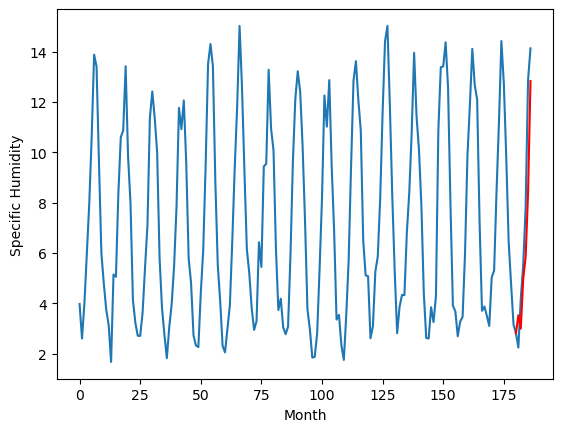

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.17		2.37		0.20
1.53		1.84		0.31
3.90		3.81		-0.09
5.21		4.69		-0.52
7.83		7.22		-0.61
12.58		11.67		-0.91
[180, 181, 182, 183, 184, 185, 186]
[2.86, 2.3739481920003893, 1.8422575944662096, 3.8092583173513415, 4.685350751280785, 7.219912862181664, 11.671516751646996]


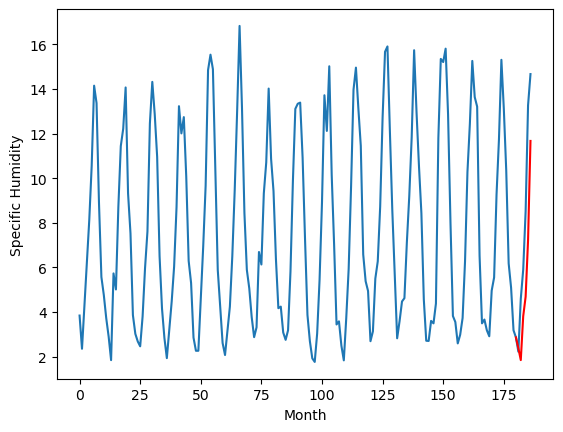

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.84		5.10		0.26
4.27		4.57		0.30
5.56		6.54		0.98
7.23		7.42		0.19
8.83		9.95		1.12
13.84		14.40		0.56
[180, 181, 182, 183, 184, 185, 186]
[2.61, 5.103944325149059, 4.572253250777721, 6.539253019988537, 7.415342533290386, 9.949903690516948, 14.40150757998228]


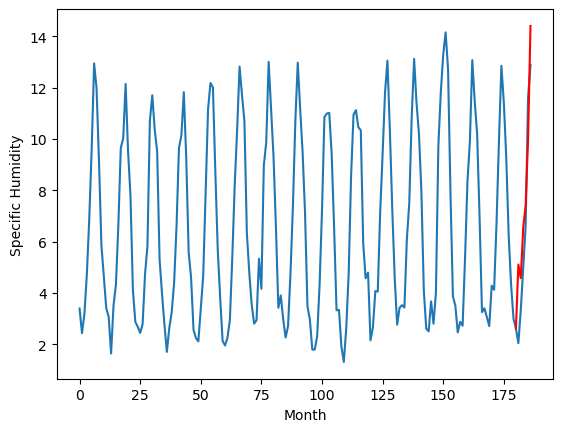

RangeIndex(start=1, stop=12, step=1)
[5.34, 4.269999999999999, 3.870000000000001, 3.7300000000000004, 3.3600000000000003, 8.64, 5.8, 3.93, 3.3000000000000003, 2.1699999999999995, 4.839999999999999]
[5.103950129151344, 3.8039443251490592, 3.8639530274271965, 3.7239530274271964, 3.283952058851719, 7.823947223424912, 5.803949160575867, 3.963952058851719, 3.5339472234249114, 2.3739481920003893, 5.103944325149059]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    5.34   5.103950
1                 1    4.27   3.803944
2                 2    3.87   3.863953
3                 3    3.73   3.723953
4                 4    3.36   3.283952
5                 5    8.64   7.823947
6                 6    5.80   5.803949
7                 7    3.93   3.963952
8                 8    3.30   3.533947
9                 9    2.17   2.373948
10               10    4.84   5.103944


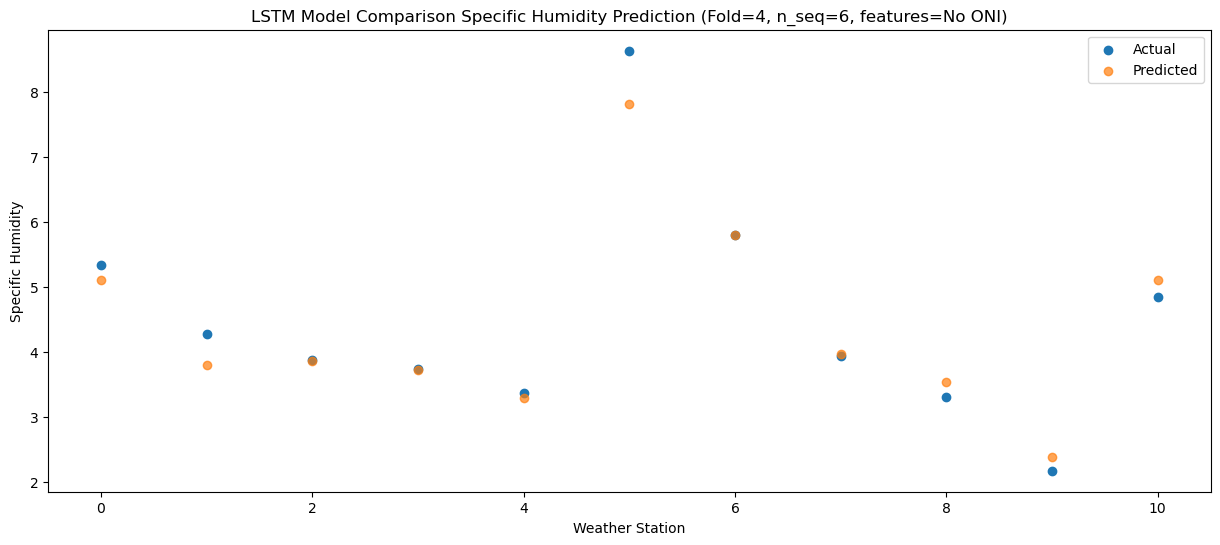

Predictions for (t+1):
    Weather_Station  Actual  Predicted
0                 0    4.25   4.572260
1                 1    6.26   3.272253
2                 2    3.75   3.332262
3                 3    3.41   3.192262
4                 4    2.91   2.752260
5                 5    8.00   7.292257
6                 6    6.05   5.272258
7                 7    3.30   3.432260
8                 8    2.73   3.002256
9                 9    1.53   1.842258
10               10    4.27   4.572253


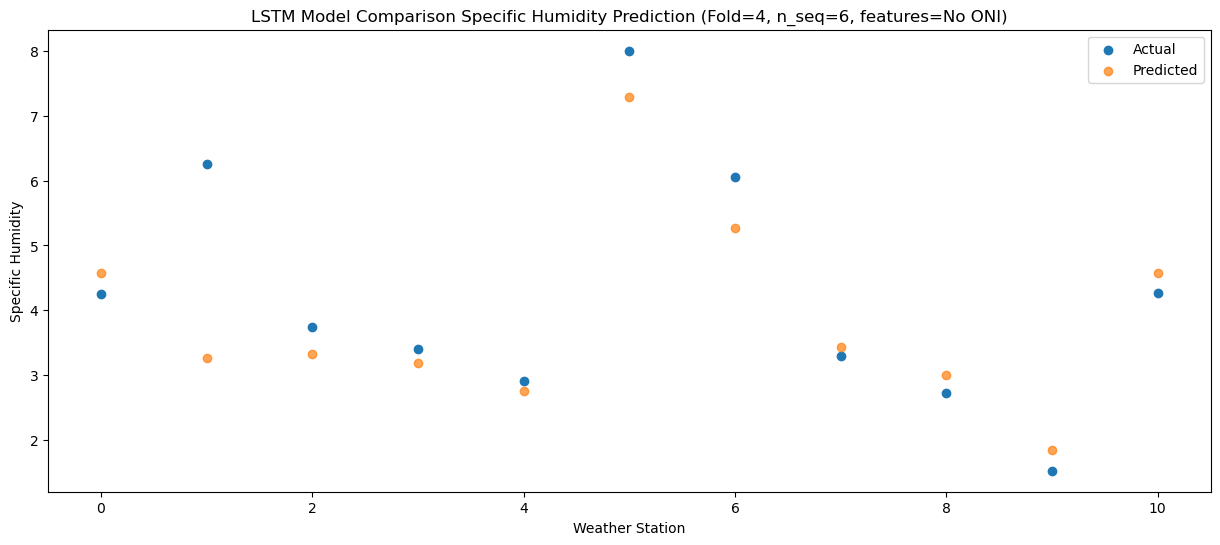

Predictions for (t+2):
    Weather_Station  Actual  Predicted
0                 0    7.01   6.539261
1                 1    6.23   5.239251
2                 2    6.81   5.299265
3                 3    6.07   5.159264
4                 4    5.49   4.719261
5                 5    9.49   9.259258
6                 6    7.76   7.239257
7                 7    5.67   5.399263
8                 8    4.67   4.969256
9                 9    3.90   3.809258
10               10    5.56   6.539253


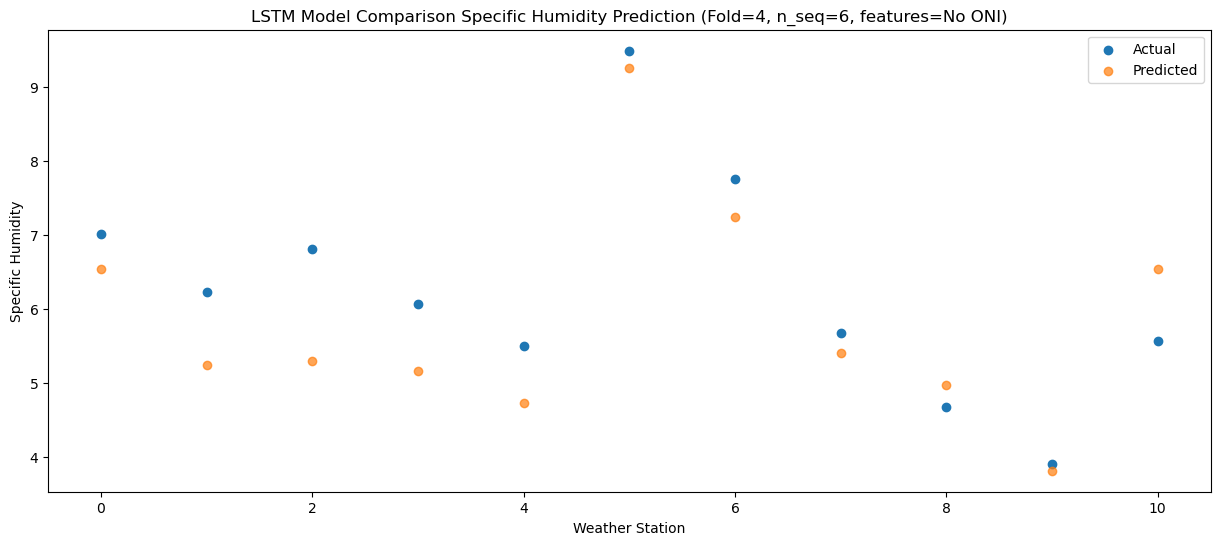

Predictions for (t+3):
    Weather_Station  Actual  Predicted
0                 0    8.22   7.415354
1                 1    6.98   6.115339
2                 2    7.06   6.175357
3                 3    7.36   6.035357
4                 4    6.85   5.595353
5                 5   10.45  10.135347
6                 6    8.17   8.115349
7                 7    6.59   6.275355
8                 8    6.00   5.845346
9                 9    5.21   4.685351
10               10    7.23   7.415343


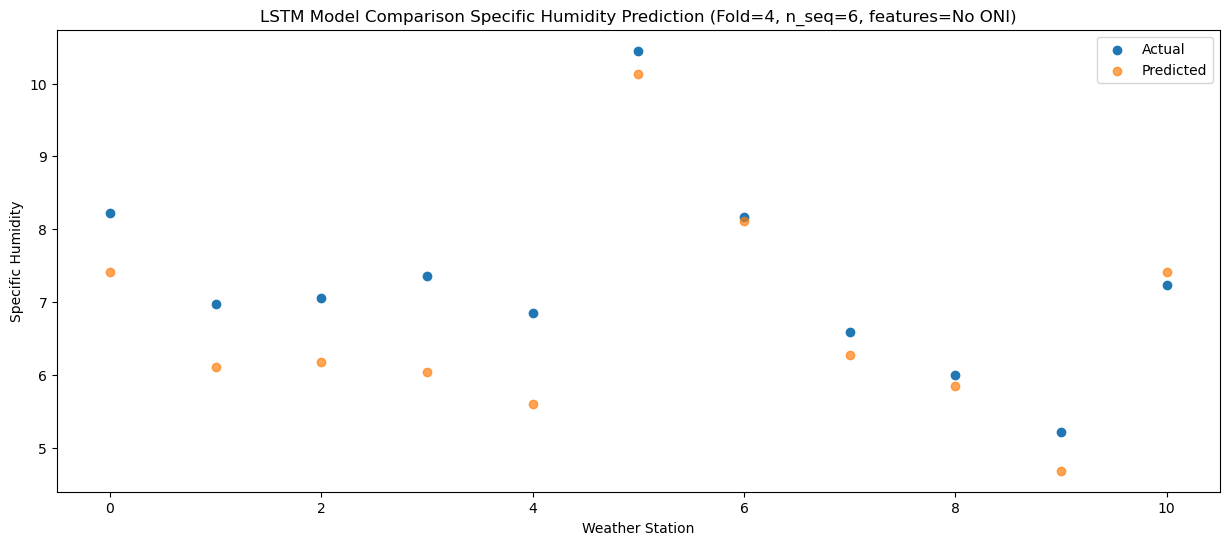

Predictions for (t+4):
    Weather_Station  Actual  Predicted
0                 0   11.78   9.949915
1                 1    8.31   8.649901
2                 2   10.50   8.709918
3                 3   11.36   8.569917
4                 4   11.14   8.129913
5                 5   15.00  12.669908
6                 6   11.15  10.649911
7                 7    9.75   8.809915
8                 8    8.29   8.379908
9                 9    7.83   7.219913
10               10    8.83   9.949904


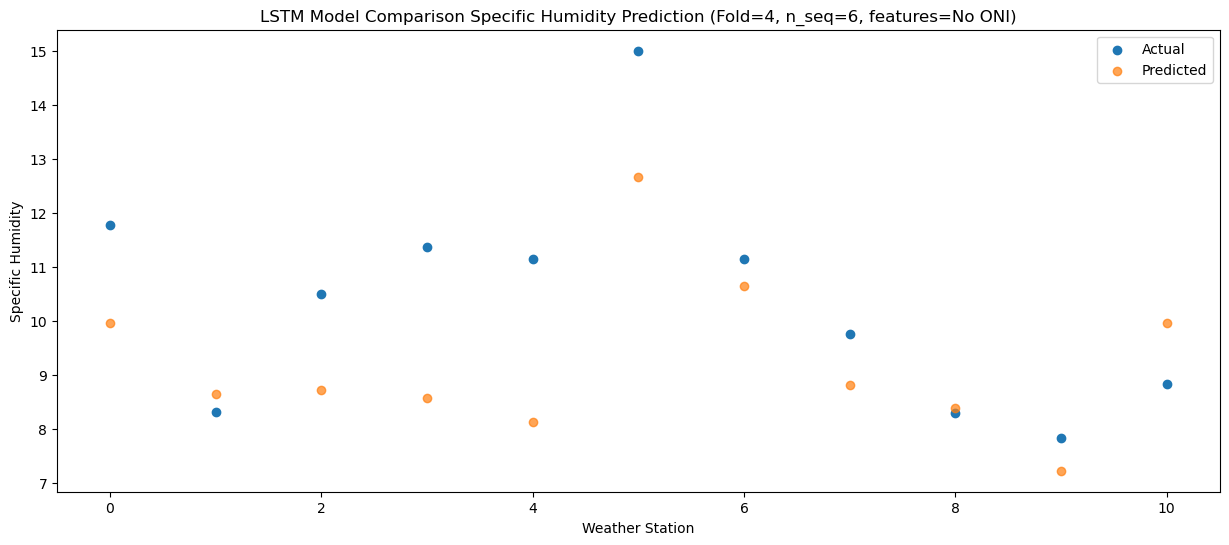

Predictions for (t+5):
    Weather_Station  Actual  Predicted
0                 0   16.37  14.401519
1                 1   12.60  13.101505
2                 2   14.74  13.161521
3                 3   15.05  13.021522
4                 4   15.02  12.581517
5                 5   17.30  17.121510
6                 6   15.84  15.101515
7                 7   14.35  13.261520
8                 8   13.35  12.831510
9                 9   12.58  11.671517
10               10   13.84  14.401508


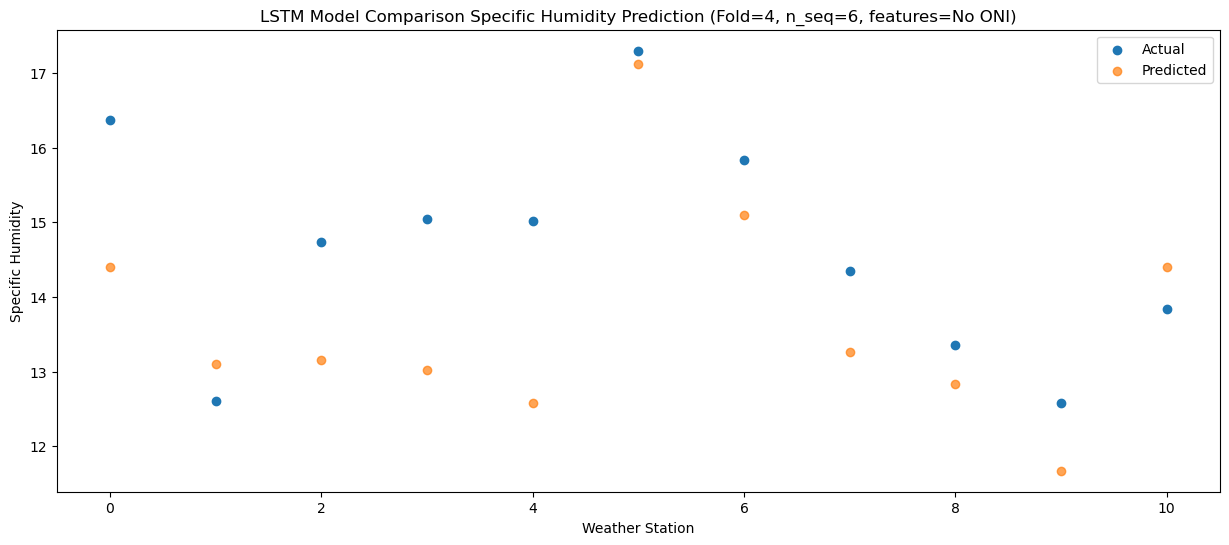

Model: "sequential_504"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1008 (LSTM)            (1, 1, 256)               2279424   
                                                                 
 dropout_1008 (Dropout)      (1, 1, 256)               0         
                                                                 
 lstm_1009 (LSTM)            (1, 256)                  525312    
                                                                 
 dropout_1009 (Dropout)      (1, 256)                  0         
                                                                 
 dense_1512 (Dense)          (1, 256)                  65792     
                                                                 
 dense_1513 (Dense)          (1, 128)                  32896     
                                                                 
 dense_1514 (Dense)          (1, 6)                 

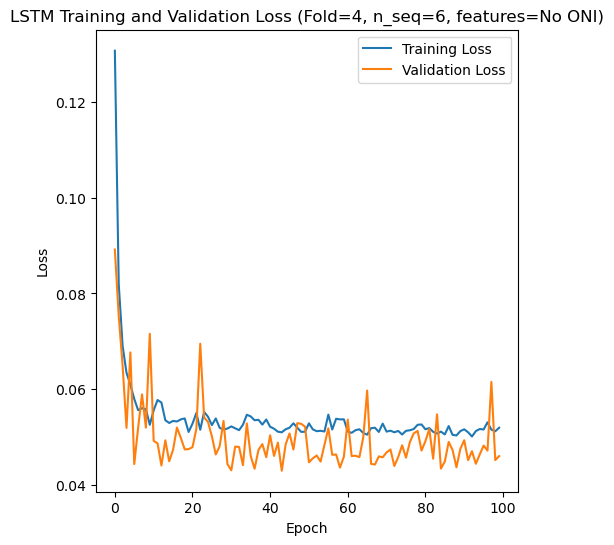

[[0.2921032745406726, 0.6186075982095879, 1.0329716465589731, 0.9691914921423358, 1.4918564561413654, 1.4002805470515023], [0.3847468047690125, 0.42512386517652195, 0.6409329877801996, 0.7977934583878459, 1.4181044273838785, 0.881062537457612], [0.6748842927309003, 1.5368524047983048, 1.9360255054326574, 2.26660043892882, 3.4412627716593995, 3.3488537364364266], [0.6088684168452505, 0.9273798256677671, 1.6335523765952142, 2.2697821165929017, 3.286686457546935, 4.9954240511669035], [0.3179318254778128, 0.9845877392040857, 0.7605868965672968, 0.7410696534348661, 1.6979126003138865, 1.3433478511096288]]
[[0.22745773808522632, 0.4965539891069581, 0.8233728084780949, 0.7204099418900228, 1.169123500748113, 1.1568691193515592], [0.2880573757128283, 0.3713236631588503, 0.5267252623493021, 0.727515052773736, 1.195089766599915, 0.7528794146125969], [0.6017397471991451, 1.159004312536933, 1.682361872304569, 1.9382266825979395, 2.977761294733394, 3.0405537491494954], [0.5129987962137568, 0.7532154

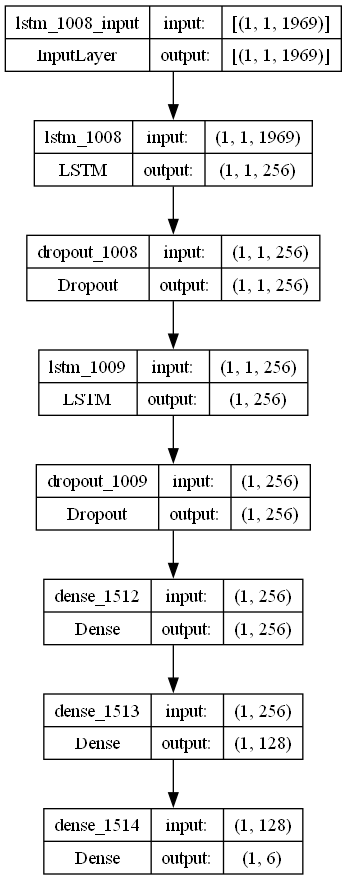

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model

def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

# Make one forecast with an LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # Create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test, n_seq, n_lag):
    # plot the entire dataset in blue
    plt.plot(series[:n_lag+2+len(forecasts)].values)
    # plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    print(xaxis)
    print(yaxis)
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Month")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 11
nb_epoch = 100

# Optimize and fit the model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

rmse_avg_list = []
mae_avg_list = []
mape_avg_list = []
r2_score_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]

    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    series = pd.Series(dataset[:, 0]) # Using first column (specific humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history=best_model.fit(X, y, epochs=nb_epoch, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction

    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse_avg_list.append(rmse_list)
    mae_avg_list.append(mae_list)
    mape_avg_list.append(mape_list)
    r2_score_avg_list.append(r2_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)

    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")
    
        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:11, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        
        plot_forecasts(series_ws, forecasts_ws, n_test, n_seq, n_lag)

    # Print out plots of actual and predicted values for weather stations
    ws = df.index[1:12]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(11):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)
            
        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No ONI)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Specific Humidity')
        plt.legend()
        plt.show()

    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No ONI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse_avg_list)
print(mae_avg_list)
print(mape_avg_list)
print(r2_score_avg_list)
print(forecast_results)
print(actual_results)
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse_avg_list)
print("Average RMSE:"+str(np.mean(rmse_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_SH_S6_No_ONI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)

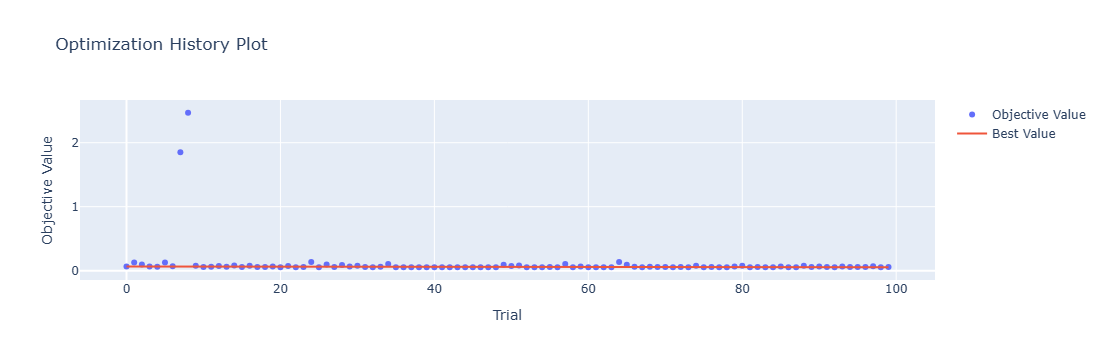

In [4]:
optuna.visualization.plot_optimization_history(study)

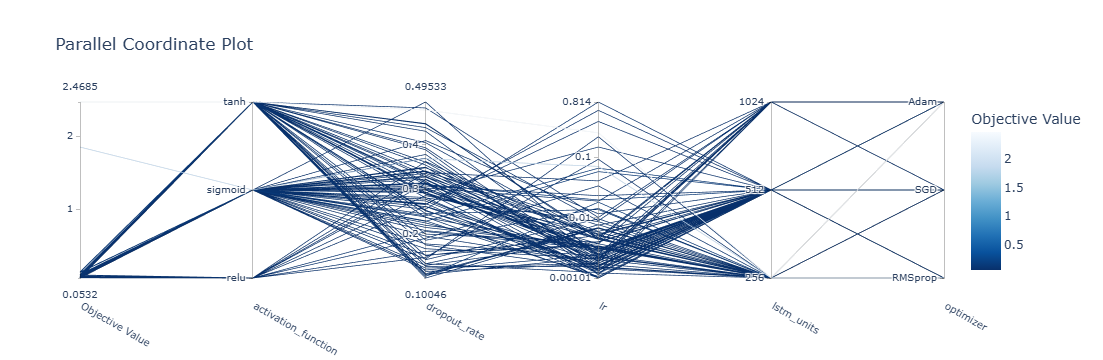

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

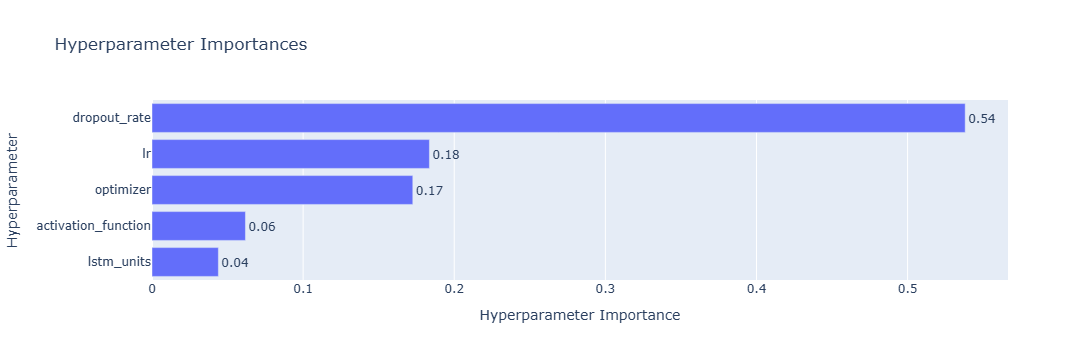

In [6]:
optuna.visualization.plot_param_importances(study)

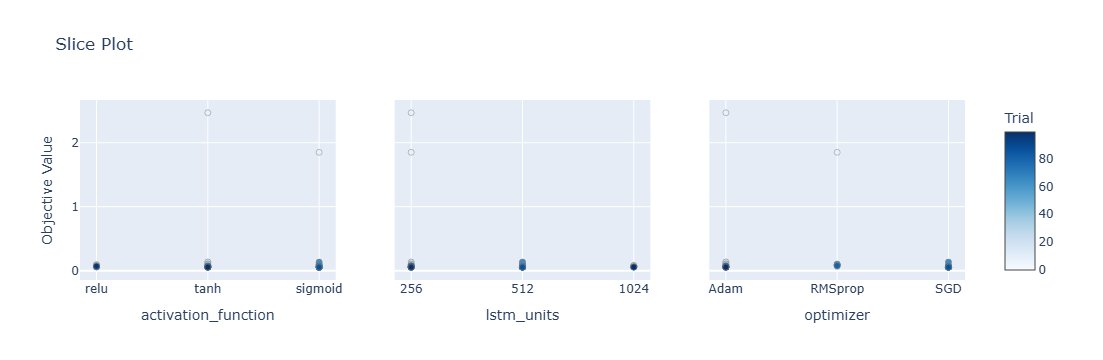

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

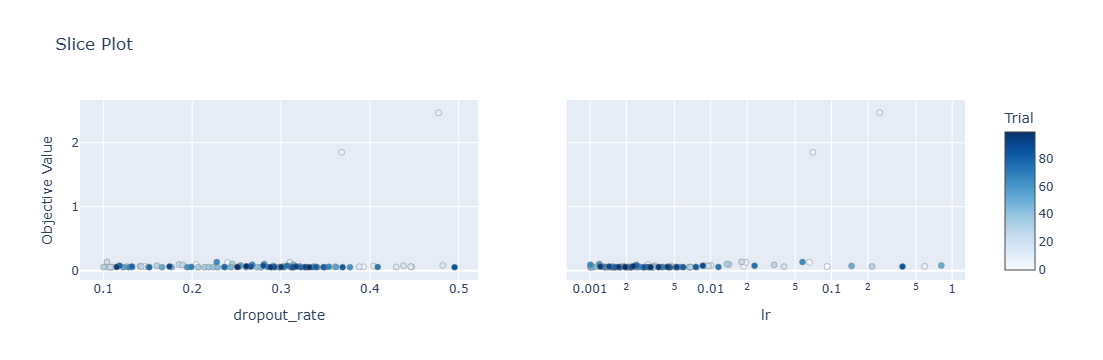

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    lr = 0.002203068435827728
    optimizer = Adam(learning_rate = lr)
    activation_function = 'tanh'
    lstm_units = 256
    dropout_rate = 0.10847270427452994

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with an LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # Create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test, n_seq, n_lag):
    # plot the entire dataset in blue
    plt.plot(series[:n_lag+2+len(forecasts)].values)
    # plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    print(xaxis)
    print(yaxis)
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Month")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 11
nb_epoch = 100
    
rmse_avg_list = []
mae_avg_list = []
mape_avg_list = []
r2_score_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]

    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    series = pd.Series(dataset[:, 0]) # Using first column (specific humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction

    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse_avg_list.append(rmse_list)
    mae_avg_list.append(mae_list)
    mape_avg_list.append(mape_list)
    r2_score_avg_list.append(r2_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)

    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")
    
        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:11, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        
        plot_forecasts(series_ws, forecasts_ws, n_test, n_seq, n_lag)

    # Print out plots of actual and predicted values for weather stations
    ws = df.index[1:12]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(11):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)
            
        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No SA)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Specific Humidity')
        plt.legend()
        plt.show()

    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No SA)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse_avg_list)
print(mae_avg_list)
print(mape_avg_list)
print(r2_score_avg_list)
print(forecast_results)
print(actual_results)
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse_avg_list)
print("Average RMSE:"+str(np.mean(rmse_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_SH_S12_No_SA.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)

Epoch 1/100
84/84 [==============================] - 40s 292ms/step - loss: 0.3833 - accuracy: 0.2024 - mae: 0.3693 - rmse: 0.3833 - mape: 61.8261 - pearson: 0.3179 - val_loss: 0.0755 - val_accuracy: 0.8000 - val_mae: 0.0605 - val_rmse: 0.0755 - val_mape: 9.6135 - val_pearson: 0.8506
Epoch 2/100
84/84 [==============================] - 20s 243ms/step - loss: 0.0614 - accuracy: 0.7976 - mae: 0.0501 - rmse: 0.0614 - mape: 8.3946 - pearson: 0.7549 - val_loss: 0.0505 - val_accuracy: 0.8000 - val_mae: 0.0420 - val_rmse: 0.0505 - val_mape: 7.2101 - val_pearson: 0.8322
Epoch 3/100
84/84 [==============================] - 21s 253ms/step - loss: 0.0601 - accuracy: 0.7976 - mae: 0.0499 - rmse: 0.0601 - mape: 8.4302 - pearson: 0.7592 - val_loss: 0.0495 - val_accuracy: 0.8000 - val_mae: 0.0404 - val_rmse: 0.0495 - val_mape: 6.8590 - val_pearson: 0.8631
Epoch 4/100
84/84 [==============================] - 21s 250ms/step - loss: 0.0594 - accuracy: 0.7976 - mae: 0.0476 - rmse: 0.0594 - mape: 8.0334 -


KeyboardInterrupt



In [ ]:
from matplotlib import pyplot

n_test_batch = 11
ws=0

# make forecasts
forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test_batch)

# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
actual = [row[-n_seq:] for row in test1]
actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

rmse_list = [] # list stores root mean squared errors for each future time prediction
mae_list = [] # list stores root mean squared errors for each future time prediction
mape_list = [] # list stores root mean squared errors for each future time prediction
r2_list = [] # list stores root mean squared errors for each future time prediction
    
# evaluate forecasts
rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

# plot forecasts
dataset_df = pd.DataFrame(val_y[0])
dataset_df = dataset_df.iloc[0:11, :]
dataset_df = dataset_df.transpose()
dataset = dataset_df.values

#print(dataset_df)

#print(len(dataset))
#print(dataset)


series_ws = pd.Series(dataset[:, ws]) # Using first column (specific_humidity)
forecasts_ws = [forecasts[ws]]

print(series_ws[180:225])
print(actual[0])
print(forecasts[0])

n_test=11
print(len(series_ws))
print(series_ws[220:228])
print(len(forecasts_ws))
print(forecasts_ws)
print(n_seq)
print(n_test)

# plot forecasts
plot_forecasts(series_ws, forecasts_ws, n_test+2)

In [ ]:
# Extract the dates corresponding to the test set predictions
test_dates = df.index[-len(actual[0]):]

# Print out plots of actual and predicted values for each weather station
for j in range(11):
    print("Weather Station "+str(j+1)+":")
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'Month': test_dates,
        'Actual': actual[j],
        'Predicted': forecasts[j]
    })
            
    # Plotting the results
    plt.figure(figsize=(15, 6))
    plt.plot(results_df['Month'], results_df['Actual'], label='Actual')
    plt.plot(results_df['Month'], results_df['Predicted'], label='Predicted', alpha=0.7)
    plt.title('LSTM Model Comparison Specific Humidity Prediction')
    plt.xlabel('Month')
    plt.ylabel('Specific Humidity')
    plt.legend()
    plt.show()

    # Plot model architecture
    filename = "lstm_model_optimized_ws_"+str(j)+".png"
    plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)

In [ ]:
print(np.mean(rmse))
print(np.std(rmse))

In [ ]:
print(len(actual))
print(len(actual[0]))
print(len(forecasts))
print(len(forecasts[0]))